<a href="https://colab.research.google.com/github/jooyeongkang/social-injustice-mimic-III/blob/main/Medication_Race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#from google.colab import files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

## PATIENTS.csv

In [ ]:
df_pat = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/PATIENTS.csv')
#df_adm = pd.read_csv('ADMISSIONS.csv')
print(df_pat.shape)
df_pat.head()

(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [ ]:
num_total = df_pat.shape[0]
print(num_total)

46520


## ADMISSIONS.csv

In [ ]:
df_adm = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
#df_adm = pd.read_csv('ADMISSIONS.csv')
print(df_adm.shape)
df_adm.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
df_adm[['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME']] = \
df_adm[['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME']].astype('datetime64', copy=True)

In [ ]:
df_adm['DIAGNOSIS'].value_counts().nlargest(n=3)

NEWBORN      7823
PNEUMONIA    1566
SEPSIS       1184
Name: DIAGNOSIS, dtype: int64

### Clean up ETHNICITY

In [ ]:
#print(df_adm['ETHNICITY'].unique())
df_adm['ETHNICITY'].replace('^WHITE\D*', 'WHITE', regex=True, inplace=True)
df_adm['ETHNICITY'].replace('^BLACK\D*', 'BLACK', regex=True, inplace=True)
df_adm['ETHNICITY'].replace('^HISPANIC\D*', 'HISPANIC/LATINO', regex=True, inplace=True)
df_adm['ETHNICITY'].replace('^ASIAN\D*', 'ASIAN', regex=True, inplace=True)
df_adm.loc[~df_adm['ETHNICITY'].isin(['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN']), 'ETHNICITY'] = 'UNKNOWN/NOT SPECIFIED'
#df_adm['ETHNICITY'].value_counts()

In [ ]:
tmp_adm = df_adm[['SUBJECT_ID', 'HADM_ID', 'ETHNICITY']].copy()

In [ ]:
print(df_adm['ETHNICITY'].value_counts())
num_white = df_adm['ETHNICITY'][df_adm['ETHNICITY']=='WHITE'].value_counts()
num_black = df_adm['ETHNICITY'][df_adm['ETHNICITY']=='BLACK'].value_counts()
num_hispanic = df_adm['ETHNICITY'][df_adm['ETHNICITY']=='HISPANIC/LATINO'].value_counts()
num_asian = df_adm['ETHNICITY'][df_adm['ETHNICITY']=='ASIAN'].value_counts()
num_unknown = df_adm['ETHNICITY'][df_adm['ETHNICITY']=='UNKNOWN/NOT SPECIFIED'].value_counts()

WHITE                    41325
UNKNOWN/NOT SPECIFIED     7731
BLACK                     5785
HISPANIC/LATINO           2128
ASIAN                     2007
Name: ETHNICITY, dtype: int64


In [ ]:
ls_ethnicity = df_adm['ETHNICITY'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


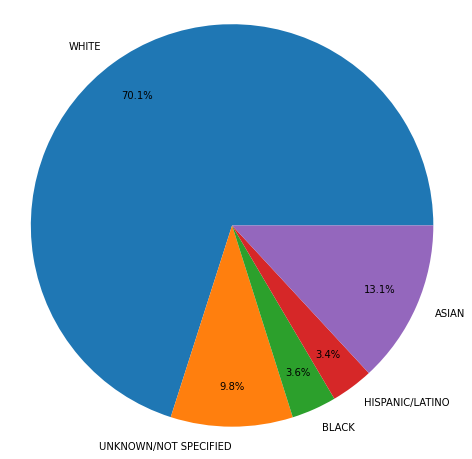

In [ ]:
labels = ls_ethnicity
sizes = [(num_white/num_total)*100,
        (num_black/num_total)*100,
        (num_hispanic/num_total)*100,
        (num_asian/num_total)*100,
        (num_unknown/num_total)*100
]

#print(sizes)

fig, ax = plt.subplots(figsize=[8,8])
ax.pie(sizes, labels=labels, autopct='%.1f%%', pctdistance=0.8)
ax.axis('equal')
plt.show()

In [ ]:
df_adm['DIAGNOSIS'].value_counts().nlargest(3)

NEWBORN      7823
PNEUMONIA    1566
SEPSIS       1184
Name: DIAGNOSIS, dtype: int64

### Dataframe for newborn patients

In [ ]:
df_adm.loc[df_adm['DIAGNOSIS'] == 'NEWBORN']
print(df_adm.loc[df_adm['DIAGNOSIS'] == 'NEWBORN'].shape)
df_adm.loc[df_adm['DIAGNOSIS'] == 'NEWBORN'].head()

(7823, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaT,NaT,NEWBORN,0,1
20,41,39,106266,2114-11-29 21:04:00,2114-12-09 15:10:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,UNKNOWN/NOT SPECIFIED,NaT,NaT,NEWBORN,0,1
27,461,358,110872,2168-10-24 23:48:00,2168-10-29 03:23:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaT,NaT,NEWBORN,0,1
34,468,363,196503,2176-03-01 15:26:00,2176-03-03 14:04:00,NaT,NEWBORN,CLINIC REFERRAL/PREMATURE,HOME,Government,NaN,PROTESTANT QUAKER,NaN,BLACK,NaT,NaT,NEWBORN,0,1
51,49,50,132761,2112-06-23 19:40:00,2112-06-26 10:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,OTHER,NaN,WHITE,NaT,NaT,NEWBORN,0,1


In [ ]:
num_total_newborn = df_adm.loc[df_adm['DIAGNOSIS'] == 'NEWBORN'].shape[0]
num_white_newborn = df_adm.loc[(df_adm['DIAGNOSIS'] == 'NEWBORN') & (df_adm['ETHNICITY'] == 'WHITE')].shape[0]
num_black_newborn = df_adm.loc[(df_adm['DIAGNOSIS'] == 'NEWBORN') & (df_adm['ETHNICITY'] == 'BLACK')].shape[0]
num_hispanic_newborn = df_adm.loc[(df_adm['DIAGNOSIS'] == 'NEWBORN') & (df_adm['ETHNICITY'] == 'HISPANIC/LATINO')].shape[0]
num_asian_newborn = df_adm.loc[(df_adm['DIAGNOSIS'] == 'NEWBORN') & (df_adm['ETHNICITY'] == 'ASIAN')].shape[0]
num_unknown_newborn = df_adm.loc[(df_adm['DIAGNOSIS'] == 'NEWBORN') & (df_adm['ETHNICITY'] == 'UNKNOWN')].shape[0]

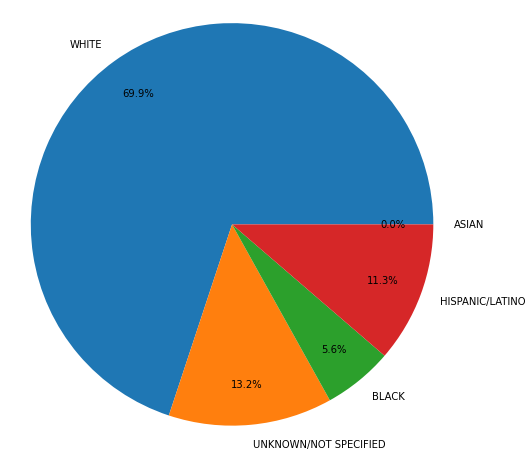

In [ ]:
labels = ls_ethnicity
sizes = [(num_white_newborn/num_total_newborn)*100,
        (num_black_newborn/num_total_newborn)*100,
        (num_hispanic_newborn/num_total_newborn)*100,
        (num_asian_newborn/num_total_newborn)*100,
        (num_unknown_newborn/num_total_newborn)*100
]

fig, ax = plt.subplots(figsize=[8,8])
ax.pie(sizes, labels=labels, autopct='%.1f%%', pctdistance=0.8)
ax.axis('equal')
plt.show()

### Dataframe for pneumonia patients

In [ ]:
df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA']
print(df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA'].shape)
df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA'].head()

(1566, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
25,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1
39,473,368,105889,2137-07-11 17:56:00,2137-07-16 16:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2137-07-11 15:00:00,2137-07-11 19:50:00,PNEUMONIA,0,1
40,474,368,138061,2139-12-16 19:48:00,2139-12-22 16:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2139-12-15 21:10:00,2139-12-16 22:05:00,PNEUMONIA,0,1
42,476,370,123421,2153-03-04 01:17:00,2153-03-08 18:57:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,NaN,JEWISH,MARRIED,WHITE,2153-03-03 14:34:00,2153-03-03 23:55:00,PNEUMONIA,0,1
71,69,68,170467,2173-12-15 16:16:00,2174-01-03 18:30:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,PROTESTANT QUAKER,SINGLE,BLACK,2173-12-15 11:41:00,2173-12-15 17:52:00,PNEUMONIA,0,1


In [ ]:
df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA'][df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA'].duplicated('SUBJECT_ID')]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
40,474,368,138061,2139-12-16 19:48:00,2139-12-22 16:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,NOT SPECIFIED,WIDOWED,WHITE,2139-12-15 21:10:00,2139-12-16 22:05:00,PNEUMONIA,0,1
1456,1445,1163,137602,2198-01-07 16:11:00,2198-01-11 16:45:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-01-07 09:11:00,2198-01-07 17:01:00,PNEUMONIA,0,1
2400,2673,2208,162248,2190-08-18 22:14:00,2190-08-24 15:27:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,ITAL,CATHOLIC,WIDOWED,WHITE,2190-08-18 12:46:00,2190-08-18 23:27:00,PNEUMONIA,0,1
2401,2674,2208,144187,2190-09-23 23:31:00,2190-09-28 16:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,ITAL,CATHOLIC,WIDOWED,WHITE,2190-09-23 19:35:00,2190-09-23 23:57:00,PNEUMONIA,0,1
2402,2675,2208,166923,2191-10-06 16:35:00,2191-10-10 17:24:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,ITAL,CATHOLIC,WIDOWED,WHITE,2191-10-06 06:27:00,2191-10-06 18:13:00,PNEUMONIA,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56969,57655,95895,145111,2130-04-14 14:59:00,2130-04-19 16:37:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,SINGLE,WHITE,2130-04-14 09:20:00,2130-04-14 16:32:00,PNEUMONIA,0,1
56970,57656,95895,149702,2130-05-03 22:02:00,2130-05-10 19:40:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,ENGL,NOT SPECIFIED,SINGLE,WHITE,2130-05-03 18:32:00,2130-05-03 23:20:00,PNEUMONIA,0,1
57191,57223,94597,124793,2170-10-30 12:10:00,2170-11-07 17:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,2170-10-30 10:43:00,2170-10-30 16:29:00,PNEUMONIA,0,1
58498,56519,92331,182206,2195-02-04 13:40:00,2195-02-23 00:00:00,2195-02-23,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,CANT,OTHER,MARRIED,ASIAN,2195-02-04 11:52:00,2195-02-04 18:47:00,PNEUMONIA,1,1


In [ ]:
num_total_pneumonia = df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA'].shape[0]
num_white_pneumonia = df_adm.loc[(df_adm['DIAGNOSIS'] == 'PNEUMONIA') & (df_adm['ETHNICITY'] == 'WHITE')].shape[0]
num_black_pneumonia = df_adm.loc[(df_adm['DIAGNOSIS'] == 'PNEUMONIA') & (df_adm['ETHNICITY'] == 'BLACK')].shape[0]
num_hispanic_pneumonia = df_adm.loc[(df_adm['DIAGNOSIS'] == 'PNEUMONIA') & (df_adm['ETHNICITY'] == 'HISPANIC/LATINO')].shape[0]
num_asian_pneumonia = df_adm.loc[(df_adm['DIAGNOSIS'] == 'PNEUMONIA') & (df_adm['ETHNICITY'] == 'ASIAN')].shape[0]
num_unknown_pneumonia = df_adm.loc[(df_adm['DIAGNOSIS'] == 'PNEUMONIA') & (df_adm['ETHNICITY'] == 'UNKNOWN')].shape[0]

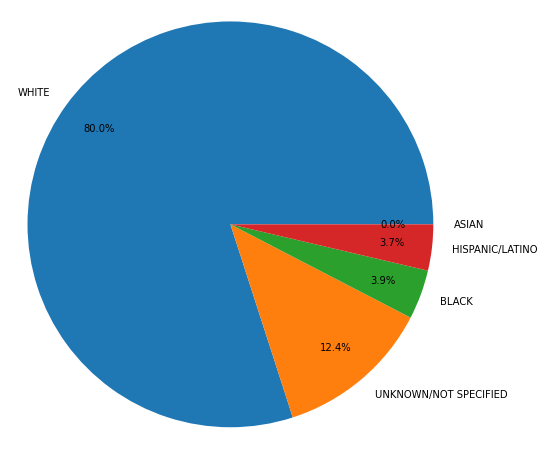

In [ ]:
labels = ls_ethnicity
sizes = [(num_white_pneumonia/num_total_pneumonia)*100,
        (num_black_pneumonia/num_total_pneumonia)*100,
        (num_hispanic_pneumonia/num_total_pneumonia)*100,
        (num_asian_pneumonia/num_total_pneumonia)*100,
        (num_unknown_pneumonia/num_total_pneumonia)*100
]

fig, ax = plt.subplots(figsize=[8,8])
ax.pie(sizes, labels=labels, autopct='%.1f%%', pctdistance=0.8)
ax.axis('equal')
plt.show()

### Dataframe for sepsis patients

In [ ]:
df_adm.loc[df_adm['DIAGNOSIS'] == 'SEPSIS']
print(df_adm.loc[df_adm['DIAGNOSIS'] == 'SEPSIS'].shape)
df_adm.loc[df_adm['DIAGNOSIS'] == 'SEPSIS'].head()

(1184, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
24,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1
37,471,366,134462,2164-11-18 20:27:00,2164-11-22 15:18:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,SINGLE,HISPANIC/LATINO,2164-11-18 10:52:00,2164-11-18 21:31:00,SEPSIS,0,1
98,96,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,CANT,NOT SPECIFIED,MARRIED,ASIAN,2176-02-25 10:35:00,2176-02-25 18:14:00,SEPSIS,0,1
230,20,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,MARRIED,WHITE,2135-01-30 18:46:00,2135-01-30 22:05:00,SEPSIS,1,1
300,448,353,108923,2151-03-28 16:01:00,2151-04-13 16:10:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,PTUN,JEWISH,SINGLE,WHITE,2151-03-28 13:02:00,2151-03-28 17:46:00,SEPSIS,0,1


In [ ]:
num_total_sepsis = df_adm.loc[df_adm['DIAGNOSIS'] == 'SEPSIS'].shape[0]
num_white_sepsis = df_adm.loc[(df_adm['DIAGNOSIS'] == 'SEPSIS') & (df_adm['ETHNICITY'] == 'WHITE')].shape[0]
num_black_sepsis = df_adm.loc[(df_adm['DIAGNOSIS'] == 'SEPSIS') & (df_adm['ETHNICITY'] == 'BLACK')].shape[0]
num_hispanic_sepsis = df_adm.loc[(df_adm['DIAGNOSIS'] == 'SEPSIS') & (df_adm['ETHNICITY'] == 'HISPANIC/LATINO')].shape[0]
num_asian_sepsis = df_adm.loc[(df_adm['DIAGNOSIS'] == 'SEPSIS') & (df_adm['ETHNICITY'] == 'ASIAN')].shape[0]
num_unknown_sepsis = df_adm.loc[(df_adm['DIAGNOSIS'] == 'SEPSIS') & (df_adm['ETHNICITY'] == 'UNKNOWN')].shape[0]

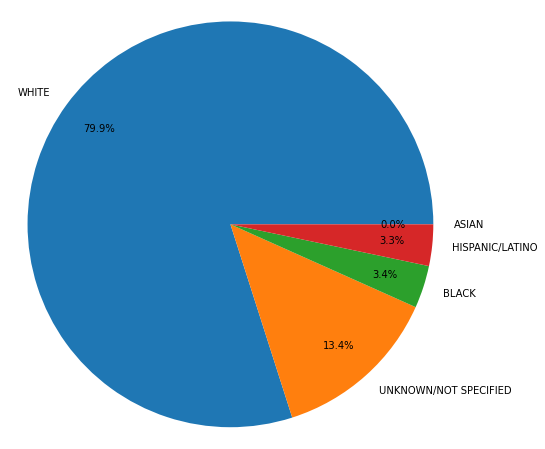

In [ ]:
labels = ls_ethnicity
sizes = [(num_white_sepsis/num_total_sepsis)*100,
        (num_black_sepsis/num_total_sepsis)*100,
        (num_hispanic_sepsis/num_total_sepsis)*100,
        (num_asian_sepsis/num_total_sepsis)*100,
        (num_unknown_sepsis/num_total_sepsis)*100
]

fig, ax = plt.subplots(figsize=[8,8])
ax.pie(sizes, labels=labels, autopct='%.1f%%', pctdistance=0.8)
ax.axis('equal')
plt.show()

In [ ]:
#patient_pneumonia = df_adm.loc[df_adm['DIAGNOSIS'] == 'PNEUMONIA', 'SUBJECT_ID'].drop_duplicates().to_numpy()

In [ ]:
# Patients who are under PNEUMONIA
#df_adm_cl = df_adm.loc[(df_adm['SUBJECT_ID'].isin(patient_pneumonia)) & (df_adm['DIAGNOSIS'] == 'PNEUMONIA')].copy()
#print(df_adm_cl.shape)
#df_adm_cl.head()

In [ ]:
"""print(df_admissions['ADMISSION_TYPE'].unique())
df_admissions['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY', inplace=True)

print(df_admissions['INSURANCE'].unique())

print(df_admissions['MARITAL_STATUS'].unique())
df_admissions['MARITAL_STATUS'].replace(['DIVORCED', 'WIDOWED'], 'SINGLE', inplace=True)
df_admissions['MARITAL_STATUS'].replace('UNKNOWN (DEFAULT)', 'UNKNOWN', inplace=True)"""

"print(df_admissions['ADMISSION_TYPE'].unique())\ndf_admissions['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY', inplace=True)\n\nprint(df_admissions['INSURANCE'].unique())\n\nprint(df_admissions['MARITAL_STATUS'].unique())\ndf_admissions['MARITAL_STATUS'].replace(['DIVORCED', 'WIDOWED'], 'SINGLE', inplace=True)\ndf_admissions['MARITAL_STATUS'].replace('UNKNOWN (DEFAULT)', 'UNKNOWN', inplace=True)"

### One-Hot Encoding: ETHNICITY

In [ ]:
"""col_categorical = []

for col in df_adm_cl.columns:
  if df_adm_cl[col].dtype == 'object':
    col_categorical.append(col)

print(col_categorical)"""

"col_categorical = []\n\nfor col in df_adm_cl.columns:\n  if df_adm_cl[col].dtype == 'object':\n    col_categorical.append(col)\n\nprint(col_categorical)"

In [ ]:
""" df_adm_cl = pd.concat([df_adm_cl, pd.get_dummies(df_adm_cl['ETHNICITY'], prefix='ETHNICITY')], axis=1)
 df_adm_cl.drop('ETHNICITY', axis=1, inplace=True)
 df_adm_cl.head()
for col in col_categorical:
  df_admissions = pd.concat([df_admissions, pd.get_dummies(df_admissions[col], prefix=col)], axis=1)
  df_admissions.drop(col, axis=1, inplace=True)"""

" df_adm_cl = pd.concat([df_adm_cl, pd.get_dummies(df_adm_cl['ETHNICITY'], prefix='ETHNICITY')], axis=1)\n df_adm_cl.drop('ETHNICITY', axis=1, inplace=True)\n df_adm_cl.head()\nfor col in col_categorical:\n  df_admissions = pd.concat([df_admissions, pd.get_dummies(df_admissions[col], prefix=col)], axis=1)\n  df_admissions.drop(col, axis=1, inplace=True)"

In [ ]:
#df_adm_cl

## PRESCRIPTIONS.csv

In [ ]:
df_prescr = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')
print(df_prescr.shape)
df_prescr.head()
#df_prescr = pd.read_csv('PRESCRIPTIONS.csv.tar.gz')
#df_prescr.rename(columns={'PRESCRIPTIONS.csv': 'ROW_ID'}, inplace=True)
#df_prescr.drop(4156450, axis=0, inplace=True)
#df_prescr[['ROW_ID', 'SUBJECT_ID', 'HADM_ID']] = df_prescr[['ROW_ID', 'SUBJECT_ID', 'HADM_ID']].astype('int64')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4156450, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


In [ ]:
ls_drugs = df_prescr['DRUG'].value_counts().nlargest(100).keys().to_numpy()

In [ ]:
tmp_drugs = df_prescr.loc[df_prescr['DRUG'].isin(ls_drugs), ['SUBJECT_ID', 'HADM_ID', 'DRUG']].copy()

In [ ]:
tmp_adm.sort_values(by='SUBJECT_ID')

,SUBJECT_ID,HADM_ID,ETHNICITY
211,2,163353,ASIAN
212,3,145834,WHITE
213,4,185777,WHITE
214,5,178980,ASIAN
215,6,107064,WHITE
...,...,...,...
56435,99985,176670,WHITE
56436,99991,151118,WHITE
56437,99992,197084,WHITE
56565,99995,137810,WHITE


In [ ]:
tmp_drugs.sort_values(by='SUBJECT_ID')

,SUBJECT_ID,HADM_ID,DRUG
130,4,185777,Acetaminophen
137,4,185777,Vancomycin HCl
134,4,185777,Ranitidine
133,4,185777,Senna
132,4,185777,Docusate Sodium
...,...,...,...
4152183,99999,113369,SW
4152184,99999,113369,SW
4152185,99999,113369,SW
4152178,99999,113369,Magnesium Sulfate


In [ ]:
tmp_drug_adm = tmp_drugs.sort_values(by='SUBJECT_ID').merge(tmp_adm.sort_values(by='SUBJECT_ID'), how='left', on=['SUBJECT_ID', 'HADM_ID'])
tmp_drug_adm

,SUBJECT_ID,HADM_ID,DRUG,ETHNICITY
0,4,185777,Acetaminophen,WHITE
1,4,185777,Vancomycin HCl,WHITE
2,4,185777,Ranitidine,WHITE
3,4,185777,Senna,WHITE
4,4,185777,Docusate Sodium,WHITE
...,...,...,...,...
3117480,99999,113369,SW,HISPANIC/LATINO
3117481,99999,113369,SW,HISPANIC/LATINO
3117482,99999,113369,SW,HISPANIC/LATINO
3117483,99999,113369,Magnesium Sulfate,HISPANIC/LATINO


### One-Hot Encoding: DRUG & ETHNICITY

In [ ]:
tmp_final = pd.concat([tmp_drug_adm, pd.get_dummies(tmp_drug_adm['DRUG'])], axis=1).groupby(['SUBJECT_ID', 'HADM_ID', 'ETHNICITY']).sum().reset_index()
tmp_final

,SUBJECT_ID,HADM_ID,ETHNICITY,0.9% Sodium Chloride,0.9% Sodium Chloride (Mini Bag Plus),1/2 NS,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Amiodarone,Amiodarone HCl,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Carbonate,Calcium Gluconate,Captopril,CefazoLIN,CefePIME,Chlorhexidine Gluconate 0.12% Oral Rinse,D5 1/2NS,D5W,Dexamethasone,Dextrose 5%,Dextrose 50%,Diazepam,Diltiazem,DiphenhydrAMINE,Docusate Sodium,Docusate Sodium (Liquid),Famotidine,Fentanyl Citrate,Furosemide,Glucagon,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Flush (10 units/ml),Heparin Flush CVL (100 units/ml),Heparin Sodium,HydrALAzine,Hydromorphone,Influenza Virus Vaccine,Insulin,Insulin Human Regular,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,Iso-Osmotic Sodium Chloride,Ketorolac,LR,Lactulose,Levofloxacin,Levothyroxine Sodium,Lisinopril,Lorazepam,Magnesium Oxide,Magnesium Sulfate,MetRONIDAZOLE (FLagyl),Metoclopramide,Metoprolol,Metoprolol Tartrate,Metronidazole,Midazolam,Milk of Magnesia,Morphine Sulfate,Multivitamins,NS,Neutra-Phos,Nitroglycerin,Norepinephrine,Ondansetron,OxycoDONE (Immediate Release),Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Phenylephrine,Phenylephrine HCl,Phenytoin Sodium,Phytonadione,Piperacillin-Tazobactam,Piperacillin-Tazobactam Na,Pneumococcal Vac Polyvalent,Potassium Chl 20 mEq / 1000 mL D5 1/2 NS,Potassium Chloride,Potassium Phosphate,PredniSONE,Propofol,Ranitidine,SW,Senna,Simvastatin,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Sterile Water,Syringe,Tacrolimus,Vancomycin,Vancomycin HCl,Vial,Warfarin,Zolpidem Tartrate
0,4,185777,WHITE,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,1,0,0,0,0,0,0,0,5,0,0,0
1,6,107064,WHITE,0,0,2,0,1,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,20,0,0,0,0,0,0,1,0,0,0,10,0,0,0,0,0,1,19,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,3,0,0,0,0,2,0,8,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,1,8,0
2,9,150750,UNKNOWN/NOT SPECIFIED,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,4,0,0,0,0,0,6,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0
3,11,194540,WHITE,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,3,1,0,0,0,0,0,2,1,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,5,1,1,2,1,0,0,3,0,0,0,0,2,2,0,0,0,0,0,1,0,0,5,0,0,0,1,0,1,0,0
4,12,112213,WHITE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,0,0,0,5,4,0,0,0,0,0,0,3,0,1,6,0,0,0,0,2,0,0,1,0,3,0,2,10,0,3,0,0,2,0,8,0,0,0,0,0,0,1,2,0,1,0,1,0,4,0,0,4,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48237,99985,176670,WHITE,15,0,0,6,4,1,0,0,0,0,1,0,0,0,0,0,0,4,1,0,1,0,0,0,0,0,1,2,0,0,4,2,0,0,0,1,1,0,0,0,0,1,0,0,1,4,0,0,0,0,1,1,0,4,0,0,1,3,0,0,0,1,0,0,0,1,1,0,1,3,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,0,3,1,0,2,3,0,0,0,1,0,0,0,0
48238,99991,151118,WHITE,10,0,1,3,3,2,0,0,0,0,0,0,0,0,3,0,0,0,1,3,0,0,0,1,0,0,0,0,0,3,1,4,1,5,0,3,1,0,0,3,0,0,2,0,4,9,2,1,7,0,0,0,2,5,0,5,1,1,0,5,0,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,4,0,0,0,6,4,0,0,0,11,0,0,0,3,0,0,0,5,0,0,0,0
48239,99992,197084,WHITE,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
48240,99995,137810,WHITE,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,1,4,1,0,0,2,0,0,0,1,0,0,1,0,0,5,0,0,0,0,0,0,4,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,1,0,1,3,0,0,3

In [ ]:
#pd.concat([tmp_final, pd.get_dummies(tmp_final['ETHNICITY'], prefix='ETHNICITY')], axis=1)

In [ ]:
"""tmp_final = pd.concat([tmp_final, pd.get_dummies(tmp_final['ETHNICITY'])], axis=1).drop('ETHNICITY', axis=1)
tmp_final"""

,SUBJECT_ID,HADM_ID,0.9% Sodium Chloride,0.9% Sodium Chloride (Mini Bag Plus),1/2 NS,5% Dextrose,Acetaminophen,Albuterol 0.083% Neb Soln,Amiodarone,Amiodarone HCl,Aspirin,Aspirin EC,Atorvastatin,Bag,Bisacodyl,Calcium Carbonate,Calcium Gluconate,Captopril,CefazoLIN,CefePIME,Chlorhexidine Gluconate 0.12% Oral Rinse,D5 1/2NS,D5W,Dexamethasone,Dextrose 5%,Dextrose 50%,Diazepam,Diltiazem,DiphenhydrAMINE,Docusate Sodium,Docusate Sodium (Liquid),Famotidine,Fentanyl Citrate,Furosemide,Glucagon,HYDROmorphone (Dilaudid),Haloperidol,Heparin,Heparin Flush (10 units/ml),Heparin Flush CVL (100 units/ml),Heparin Sodium,HydrALAzine,Hydromorphone,Influenza Virus Vaccine,Insulin,Insulin Human Regular,Ipratropium Bromide Neb,Iso-Osmotic Dextrose,Iso-Osmotic Sodium Chloride,Ketorolac,LR,Lactulose,Levofloxacin,Levothyroxine Sodium,Lisinopril,Lorazepam,Magnesium Oxide,Magnesium Sulfate,MetRONIDAZOLE (FLagyl),Metoclopramide,Metoprolol,Metoprolol Tartrate,Metronidazole,Midazolam,Milk of Magnesia,Morphine Sulfate,Multivitamins,NS,Neutra-Phos,Nitroglycerin,Norepinephrine,Ondansetron,OxycoDONE (Immediate Release),Oxycodone-Acetaminophen,Pantoprazole,Pantoprazole Sodium,Phenylephrine,Phenylephrine HCl,Phenytoin Sodium,Phytonadione,Piperacillin-Tazobactam,Piperacillin-Tazobactam Na,Pneumococcal Vac Polyvalent,Potassium Chl 20 mEq / 1000 mL D5 1/2 NS,Potassium Chloride,Potassium Phosphate,PredniSONE,Propofol,Ranitidine,SW,Senna,Simvastatin,Sodium Bicarbonate,Sodium Chloride 0.9% Flush,Sterile Water,Syringe,Tacrolimus,Vancomycin,Vancomycin HCl,Vial,Warfarin,Zolpidem Tartrate,ASIAN,BLACK,HISPANIC/LATINO,UNKNOWN/NOT SPECIFIED,WHITE
0,4,185777,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,1,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1
1,6,107064,0,0,2,0,1,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,20,0,0,0,0,0,0,1,0,0,0,10,0,0,0,0,0,1,19,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,3,0,0,0,0,2,0,8,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,1,8,0,0,0,0,0,1
2,9,150750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,4,0,0,0,0,0,6,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,11,194540,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,3,1,0,0,0,0,0,2,1,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,5,1,1,2,1,0,0,3,0,0,0,0,2,2,0,0,0,0,0,1,0,0,5,0,0,0,1,0,1,0,0,0,0,0,0,1
4,12,112213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,0,0,0,5,4,0,0,0,0,0,0,3,0,1,6,0,0,0,0,2,0,0,1,0,3,0,2,10,0,3,0,0,2,0,8,0,0,0,0,0,0,1,2,0,1,0,1,0,4,0,0,4,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48237,99985,176670,15,0,0,6,4,1,0,0,0,0,1,0,0,0,0,0,0,4,1,0,1,0,0,0,0,0,1,2,0,0,4,2,0,0,0,1,1,0,0,0,0,1,0,0,1,4,0,0,0,0,1,1,0,4,0,0,1,3,0,0,0,1,0,0,0,1,1,0,1,3,0,0,2,0,0,0,0,0,0,0,0,0,5,0,0,0,0,3,1,0,2,3,0,0,0,1,0,0,0,0,0,0,0,0,1
48238,99991,151118,10,0,1,3,3,2,0,0,0,0,0,0,0,0,3,0,0,0,1,3,0,0,0,1,0,0,0,0,0,3,1,4,1,5,0,3,1,0,0,3,0,0,2,0,4,9,2,1,7,0,0,0,2,5,0,5,1,1,0,5,0,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,4,0,0,0,6,4,0,0,0,11,0,0,0,3,0,0,0,5,0,0,0,0,0,0,0,0,1
48239,99992,197084,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
48240,99995,137810,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,1,4,1,0,0,2,0,0,0,1,0,0,1,0,0,5,0,0,0,0,0,0,4,0,0,1,0,0,0,2

In [ ]:
ls_total = []
data = pd.DataFrame(ls_ethnicity, columns=['ETHNICITY'])

for drug in ls_drugs:
  ls_mean = []
  for race in ls_ethnicity:
    ls_mean.append(tmp_final.loc[tmp_final['ETHNICITY'] == race, drug].mean())
  ls_total.append(ls_mean)
  data = pd.concat([data, pd.DataFrame(ls_mean, columns=[drug])], axis=1)

data

,ETHNICITY,Potassium Chloride,Insulin,D5W,Furosemide,0.9% Sodium Chloride,NS,Magnesium Sulfate,Iso-Osmotic Dextrose,Sodium Chloride 0.9% Flush,Acetaminophen,Metoprolol,5% Dextrose,SW,Morphine Sulfate,Metoprolol Tartrate,Lorazepam,Calcium Gluconate,Heparin,Docusate Sodium,Vancomycin,Bisacodyl,Warfarin,Heparin Sodium,HYDROmorphone (Dilaudid),LR,Propofol,Pantoprazole,Fentanyl Citrate,Senna,Aspirin,Bag,Vial,Vancomycin HCl,Albuterol 0.083% Neb Soln,Dextrose 50%,Oxycodone-Acetaminophen,Ondansetron,Levofloxacin,Haloperidol,Ranitidine,Aspirin EC,Ipratropium Bromide Neb,Famotidine,Lisinopril,Sodium Bicarbonate,Neutra-Phos,Potassium Phosphate,Pantoprazole Sodium,Atorvastatin,Nitroglycerin,HydrALAzine,Diltiazem,D5 1/2NS,Metoclopramide,Amiodarone,Docusate Sodium (Liquid),Sterile Water,0.9% Sodium Chloride (Mini Bag Plus),Midazolam,Syringe,Amiodarone HCl,Milk of Magnesia,OxycoDONE (Immediate Release),Tacrolimus,Levothyroxine Sodium,Hydromorphone,PredniSONE,Insulin Human Regular,Captopril,Iso-Osmotic Sodium Chloride,Glucagon,Chlorhexidine Gluconate 0.12% Oral Rinse,Lactulose,Heparin Flush (10 units/ml),Phenylephrine,Phytonadione,Dexamethasone,Multivitamins,Phenytoin Sodium,Diazepam,Influenza Virus Vaccine,1/2 NS,Norepinephrine,MetRONIDAZOLE (FLagyl),Dextrose 5%,Simvastatin,Zolpidem Tartrate,Piperacillin-Tazobactam Na,Ketorolac,Pneumococcal Vac Polyvalent,CefazoLIN,Potassium Chl 20 mEq / 1000 mL D5 1/2 NS,CefePIME,Piperacillin-Tazobactam,Heparin Flush CVL (100 units/ml),Metronidazole,Calcium Carbonate,Phenylephrine HCl,Magnesium Oxide,DiphenhydrAMINE
0,WHITE,4.091551,2.824274,2.967834,2.889921,2.654239,2.770407,1.913767,1.802059,1.767891,1.660272,1.559285,1.520858,1.552938,1.324975,1.320200,1.207377,1.082144,1.088721,0.963117,0.885432,0.876140,0.864103,0.801716,0.810665,0.781358,0.729550,0.701101,0.651351,0.610979,0.604375,0.513996,0.508535,0.457756,0.479685,0.437427,0.452323,0.447491,0.438399,0.451380,0.429507,0.401029,0.404403,0.386590,0.371723,0.375840,0.377012,0.374353,0.375640,0.366862,0.355025,0.324861,0.370122,0.339929,0.334382,0.372838,0.334439,0.276226,0.280515,0.284946,0.291837,0.273796,0.276769,0.264074,0.231337,0.273481,0.265761,0.242974,0.242373,0.225704,0.236798,0.229736,0.245919,0.237112,0.237112,0.249035,0.229850,0.230450,0.233281,0.218985,0.229736,0.222416,0.214325,0.211265,0.215668,0.204546,0.210407,0.204975,0.198628,0.195854,0.201201,0.194139,0.193881,0.175897,0.172466,0.178985,0.174096,0.176469,0.165147,0.168006,0.172352
1,UNKNOWN/NOT SPECIFIED,4.315213,2.786150,3.672587,3.055436,2.760136,2.439003,1.925009,1.855041,1.527628,1.728023,1.942770,1.710083,1.571224,1.294403,1.090240,1.069968,1.261213,0.952637,1.018479,0.804629,0.832795,0.845892,0.924291,0.610693,0.629171,0.818981,0.681019,0.783280,0.504665,0.611769,0.627736,0.442770,0.614460,0.353068,0.476857,0.558845,0.381593,0.431468,0.430032,0.604055,0.610693,0.335307,0.398098,0.395587,0.446358,0.325798,0.377646,0.316290,0.438105,0.469142,0.294223,0.279691,0.279871,0.408683,0.295300,0.362935,0.397381,0.301758,0.297991,0.337280,0.509867,0.345533,0.207391,0.212235,0.203445,0.221026,0.170255,0.256907,0.393613,0.274130,0.256189,0.250269,0.233943,0.188733,0.222641,0.220129,0.161105,0.207571,0.231252,0.173305,0.194116,0.165949,0.253319,0.144779,0.202009,0.182992,0.207930,0.183710,0.240402,0.205777,0.186042,0.159132,0.154647,0.191066,0.150161,0.193039,0.130068,0.312343,0.193219,0.105310
2,BLACK,3.196128,4.234428,2.343434,1.963384,2.745160,2.463384,1.630471,1.807239,1.655934,1.347222,1.147306,1.396465,1.188131,1.017677,0.902778,0.924032,0.877315,1.174663,0.803451,0.964646,0.726852,0.620160,0.548822,0.741372,0.544823,0.500842,0.711069,0.565236,0.682660,0.515993,0.521886,0.576810,0.388468,0.470960,0.510732,0.288721,0.430556,0.425505,0.328914,0.180556,0.173611,0.394360,0.344487,0.507786,0.400884,0.358586,0.307449,0.321128,0.273990,0.198653,0.497054,0.241162,0.365320,0.268098,0.151305,0.260732,0.275042,0.316288,0.257365,0.126894,0.089015,0.126684,0.278199,0.335438,0.159512,0.176557,0.33

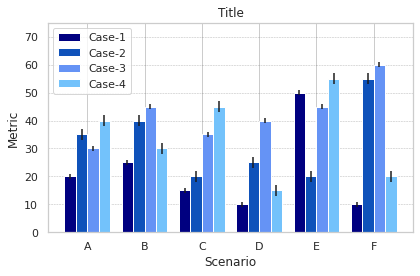

In [ ]:
data = np.array([[20, 35, 30, 40], [25, 40, 45, 30], 
                 [15, 20, 35, 45], [10, 25, 40, 15], 
                 [50, 20, 45, 55], [10, 55, 60, 20]])
data_std = np.array([[1, 2, 1, 2], [1, 2, 1, 2], [1, 2, 1, 2], 
                     [1, 2, 1, 2], [1, 2, 1, 2], [1, 2, 1, 2]])    

length = len(data)
x_labels = ls_drugs

# Set plot parameters
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='Case-1', yerr=data_std[:,0])
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Case-2', yerr=data_std[:,1])
ax.bar(x + (2 * width), data[:,2], width, color='#6593F5', label='Case-3', yerr=data_std[:,2])
ax.bar(x + (3 * width), data[:,3], width, color='#73C2FB', label='Case-4', yerr=data_std[:,3])

ax.set_ylabel('Metric')
ax.set_ylim(0,75)
ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Scenario')
ax.set_title('Title')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

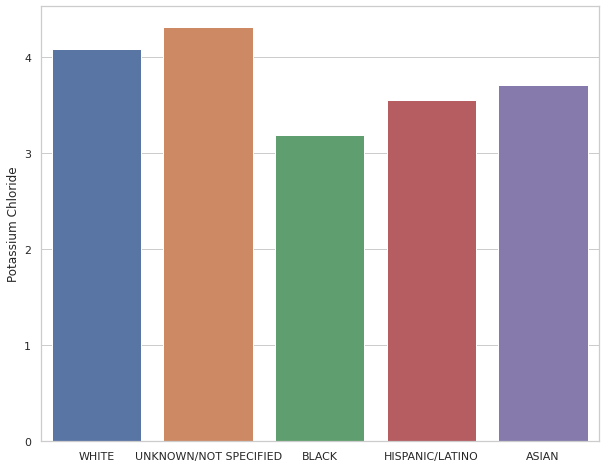

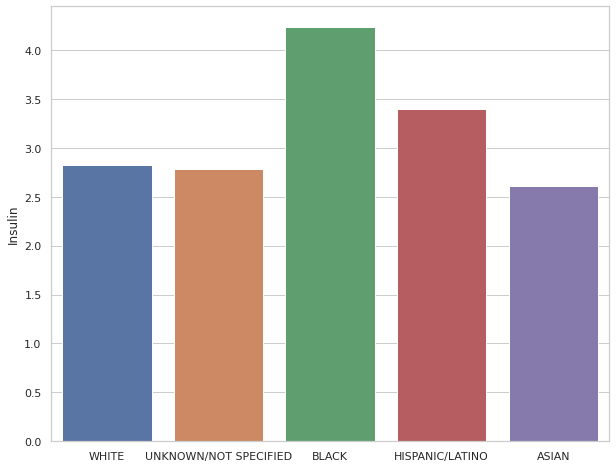

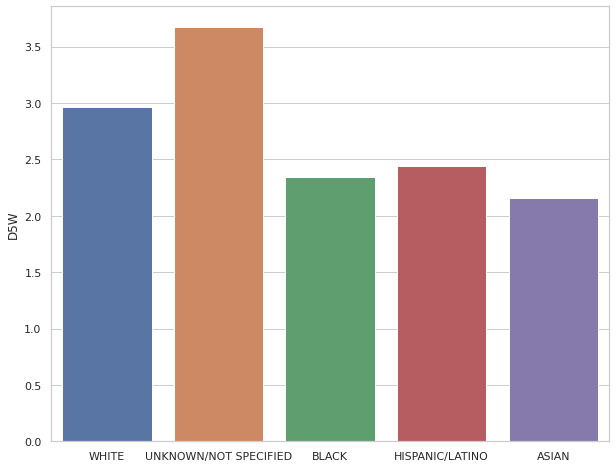

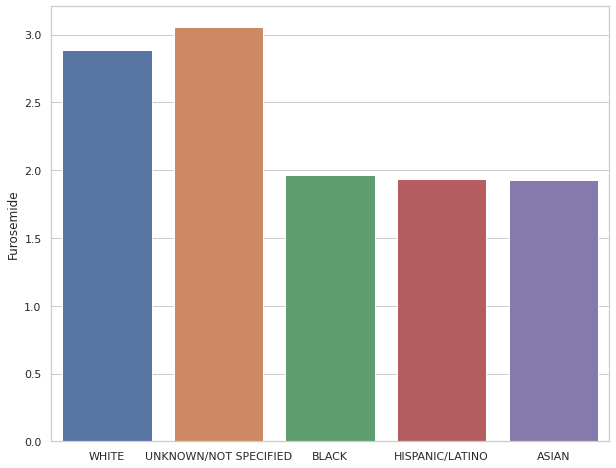

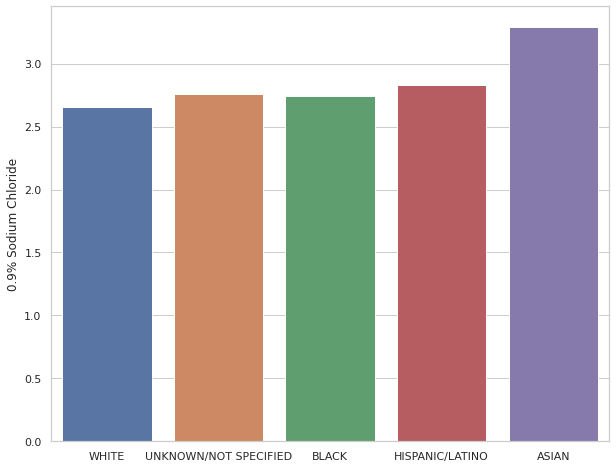

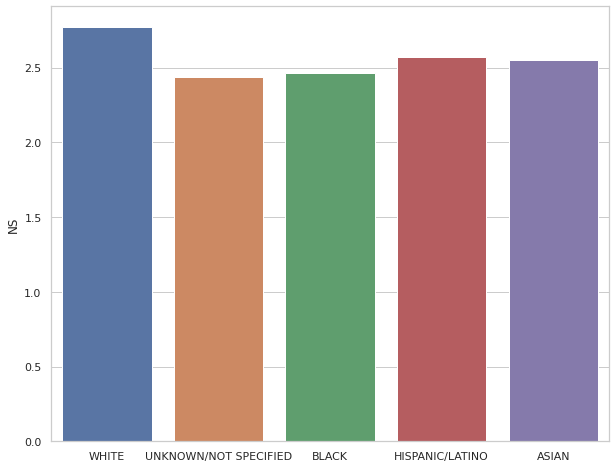

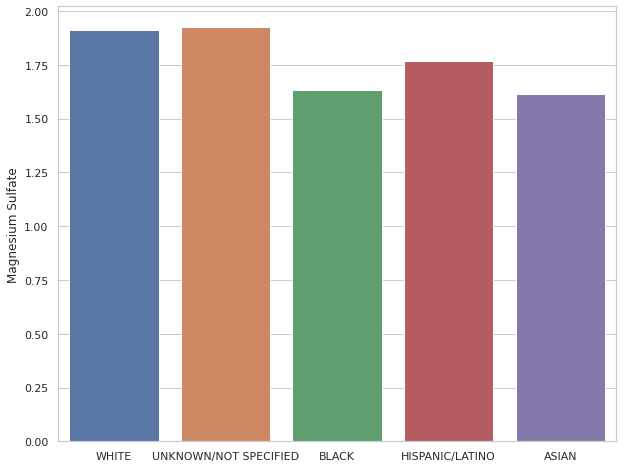

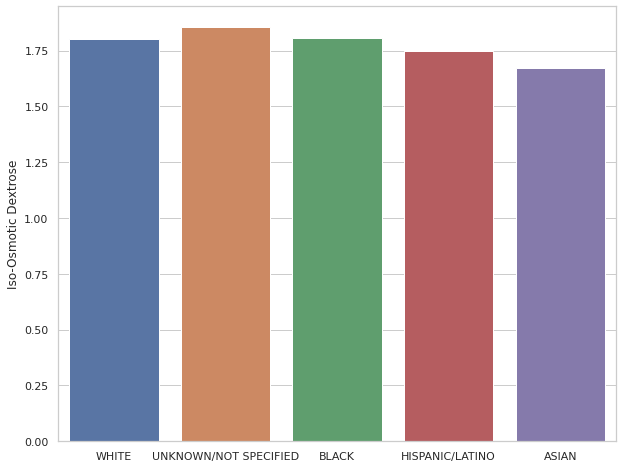

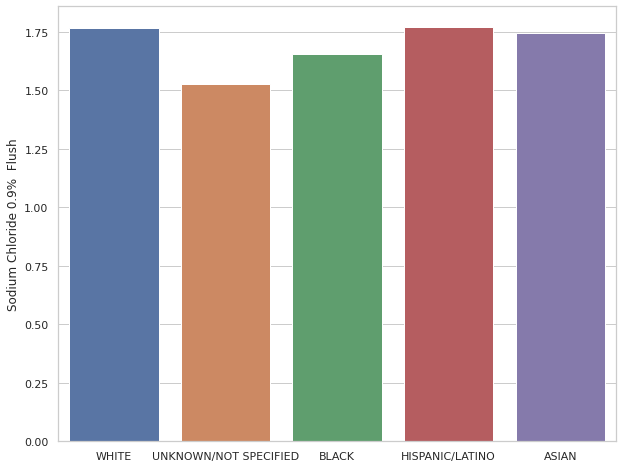

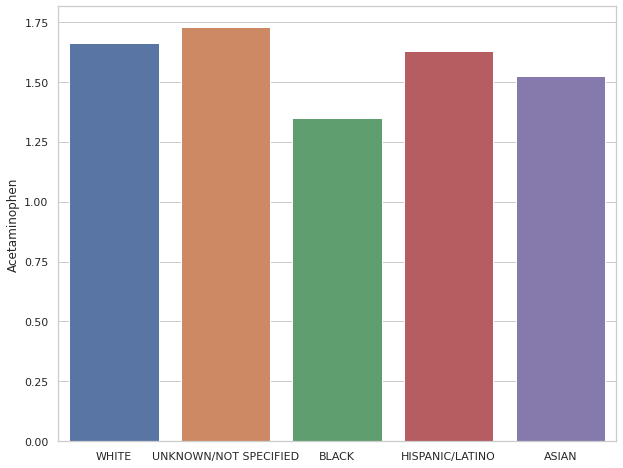

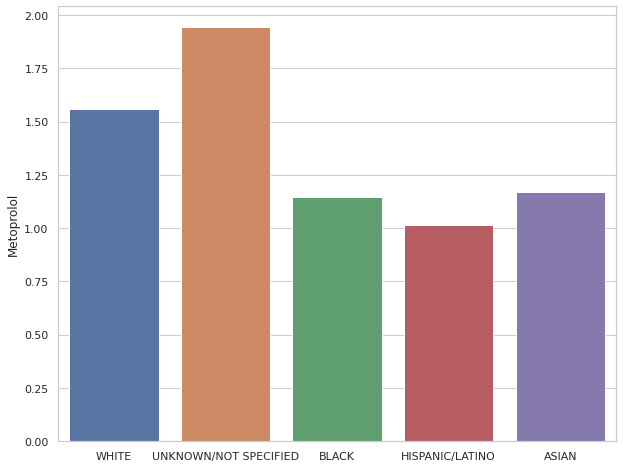

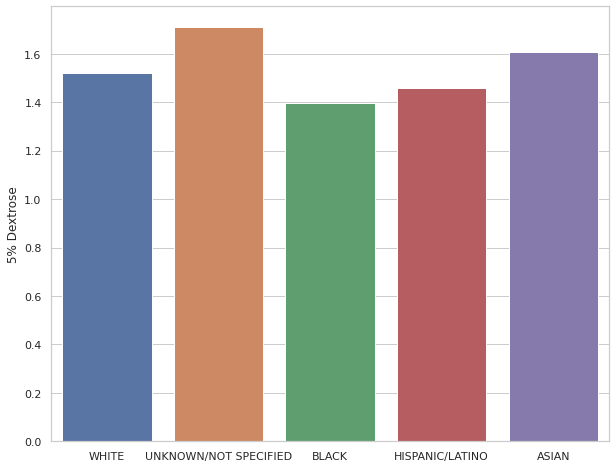

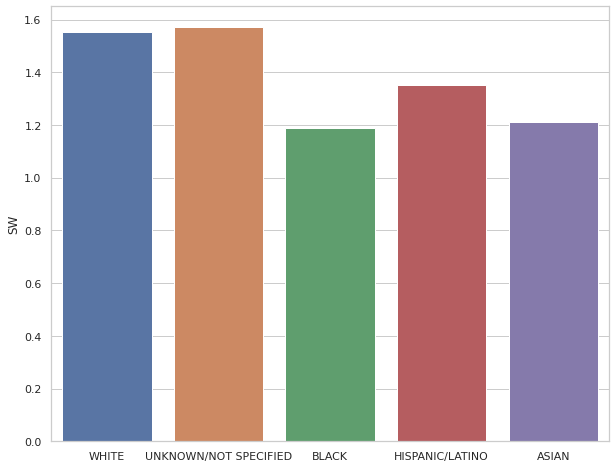

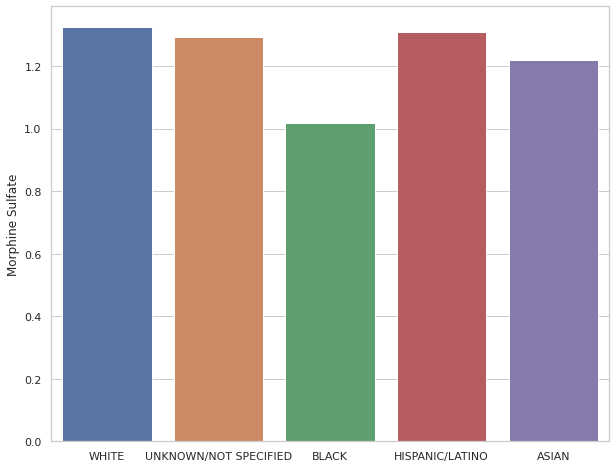

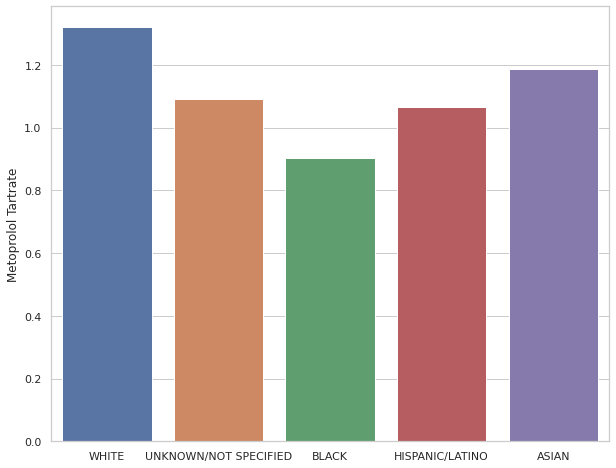

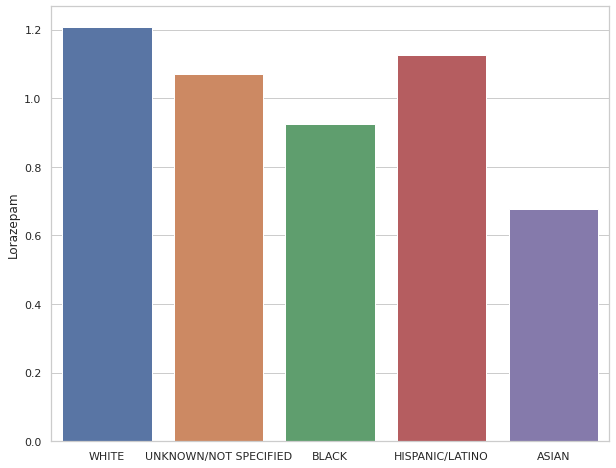

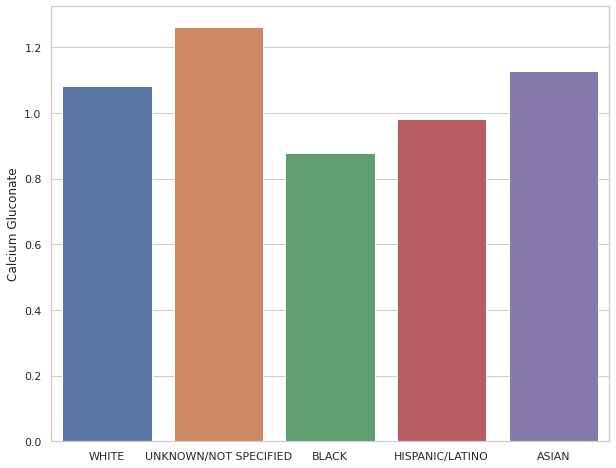

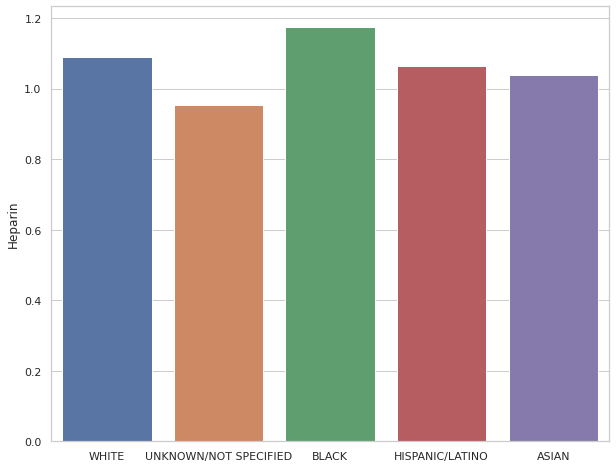

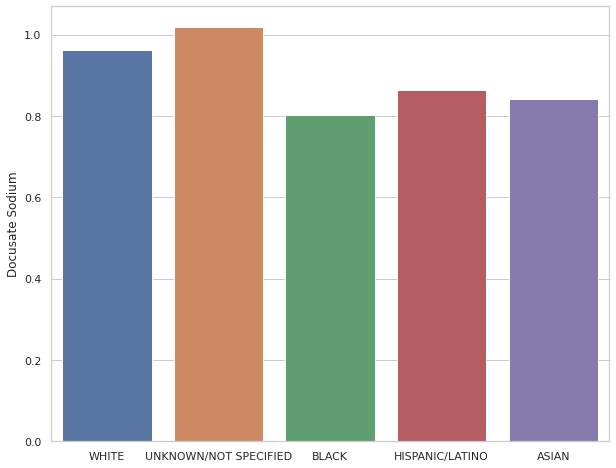

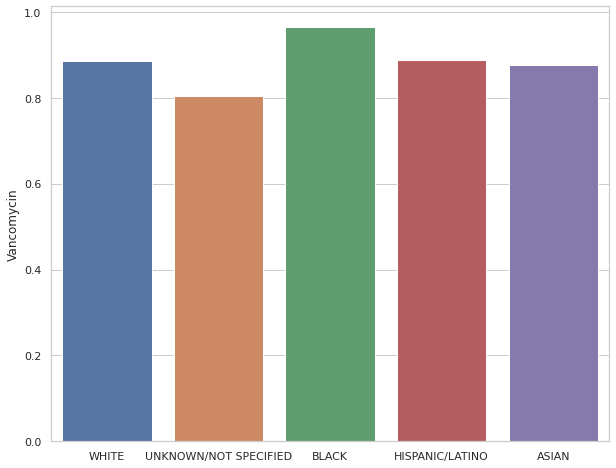

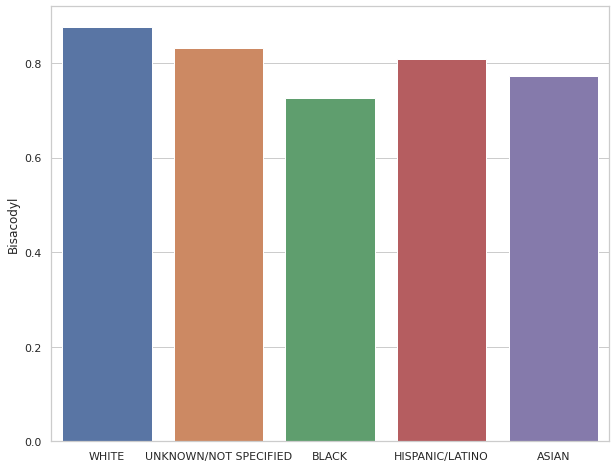

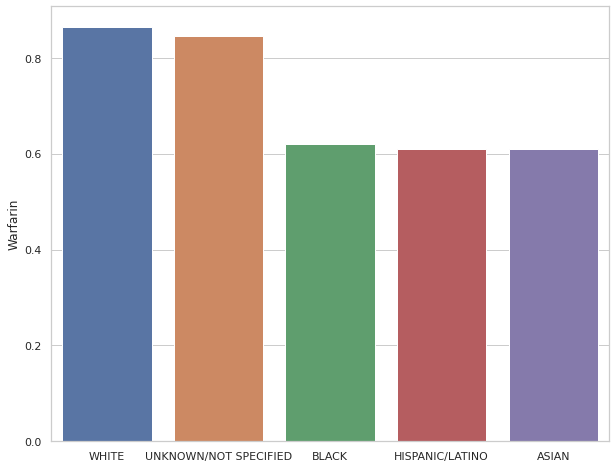

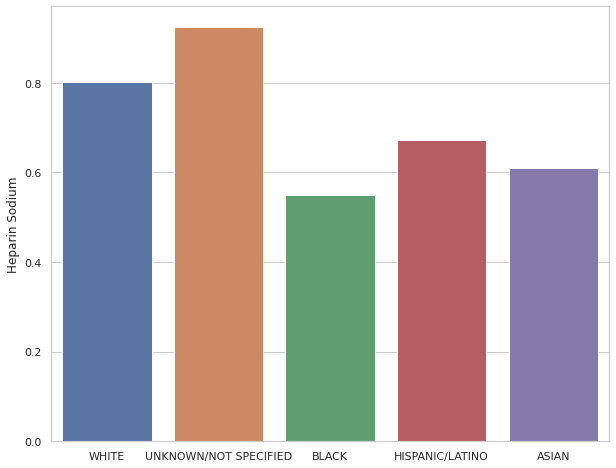

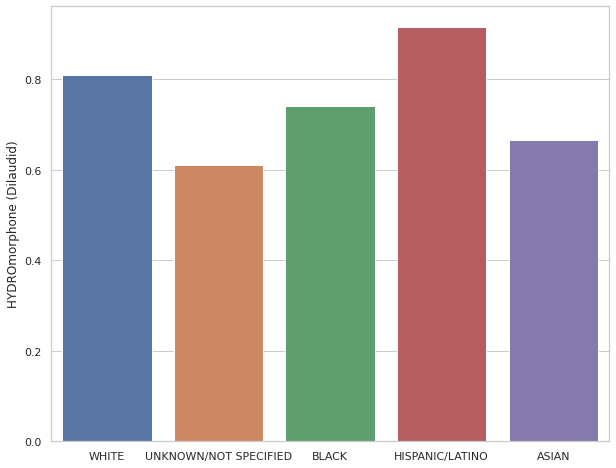

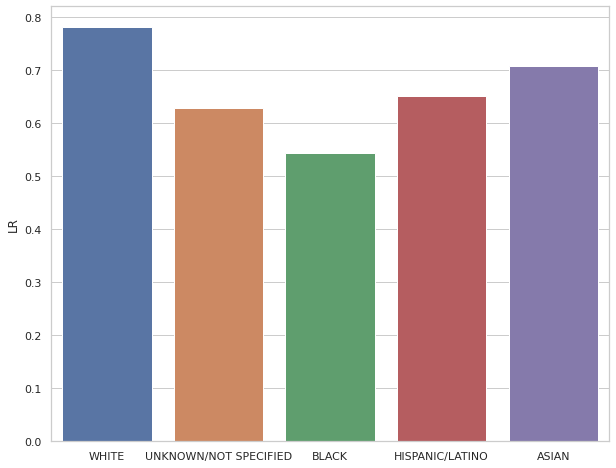

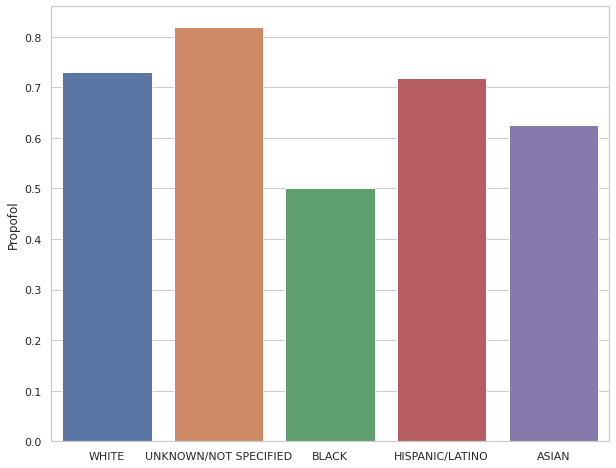

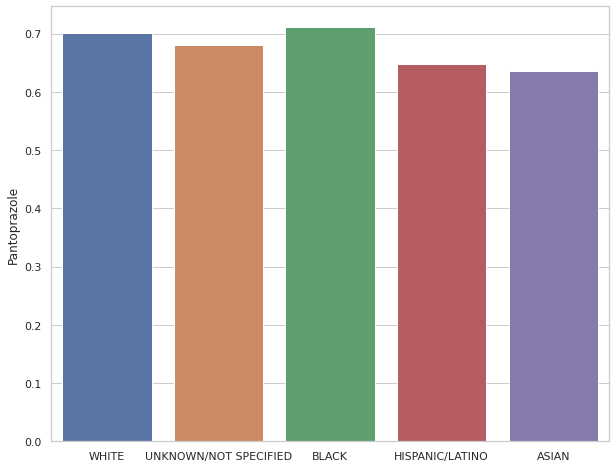

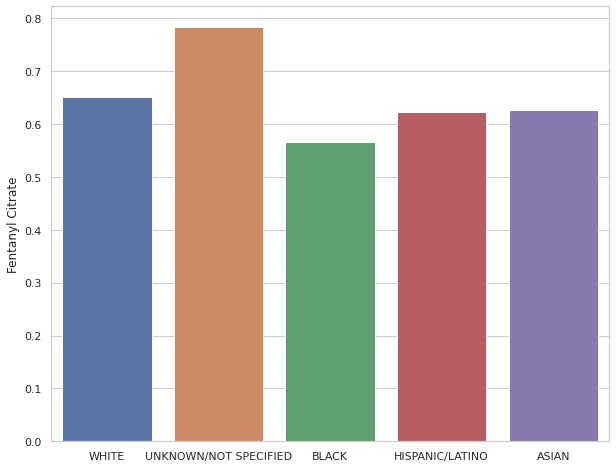

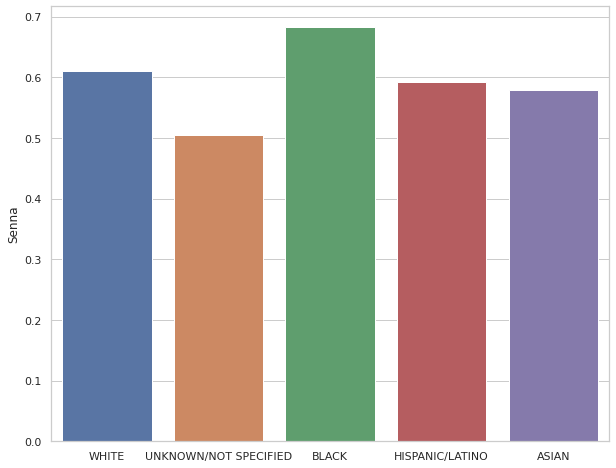

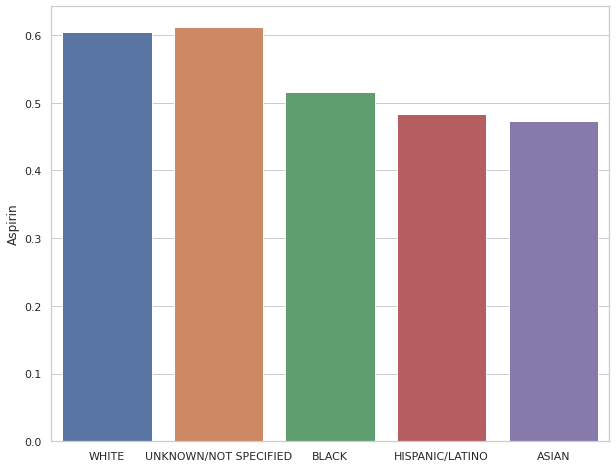

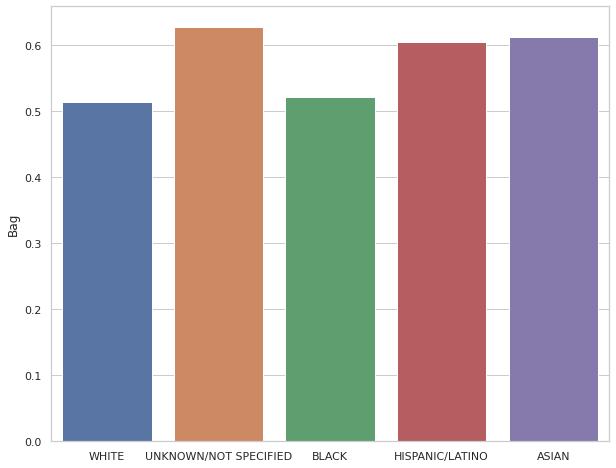

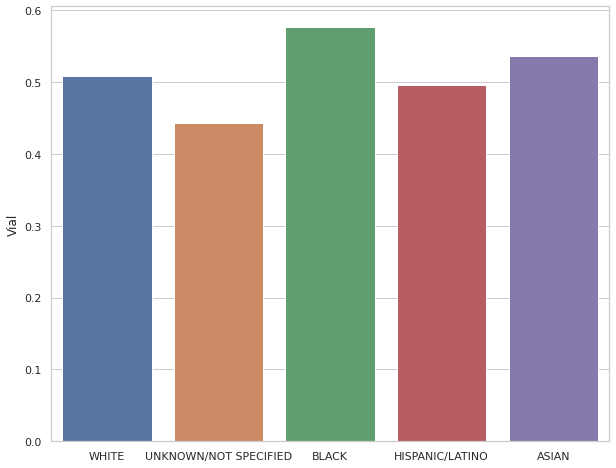

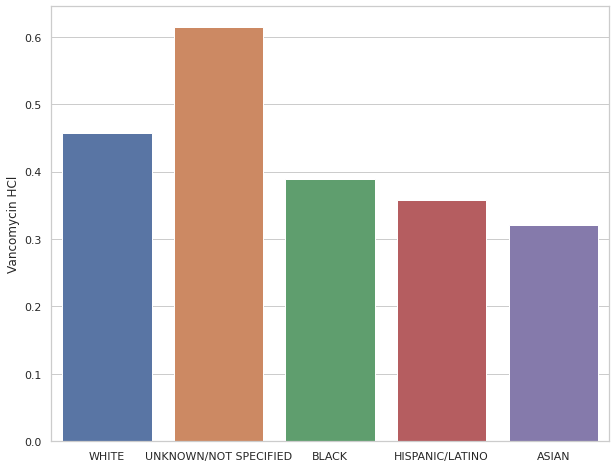

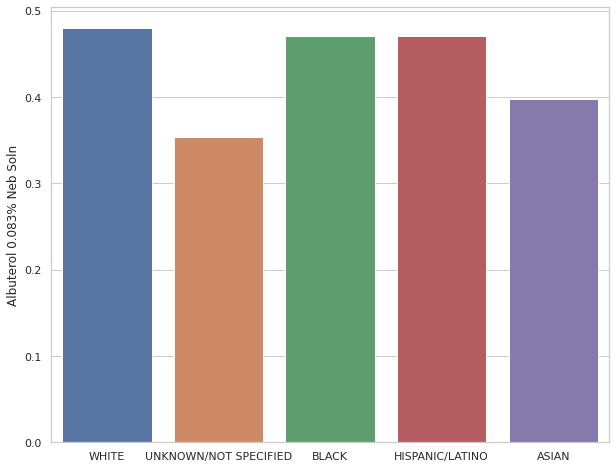

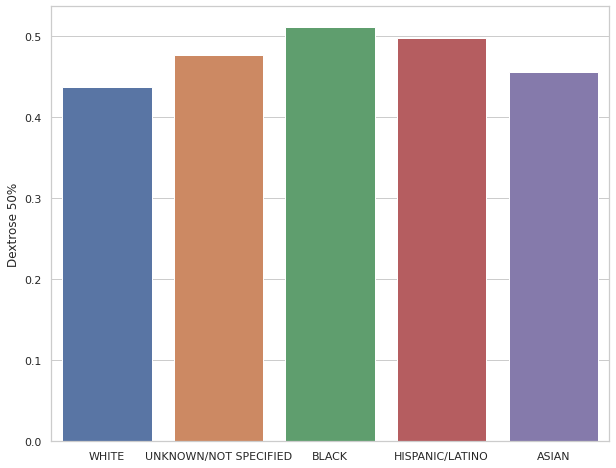

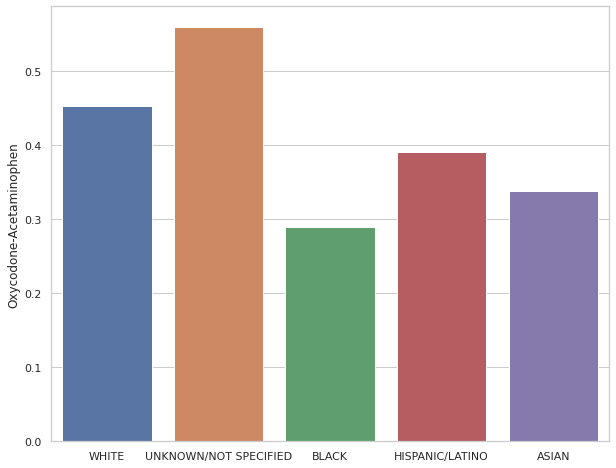

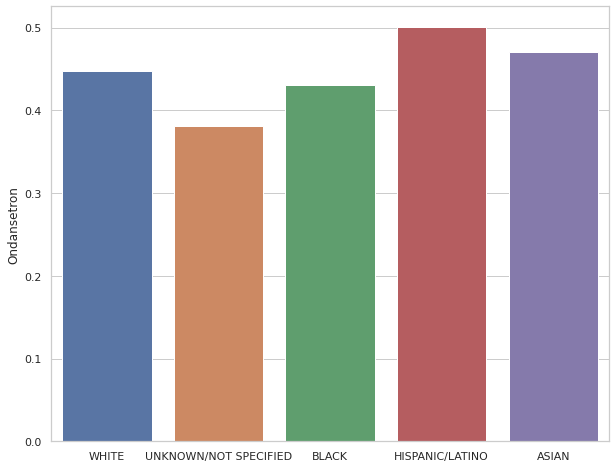

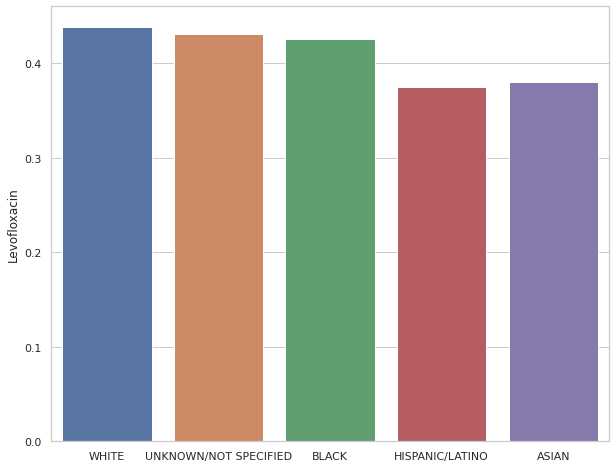

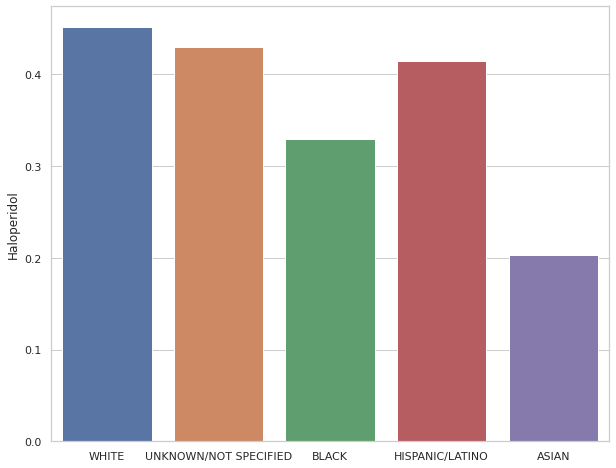

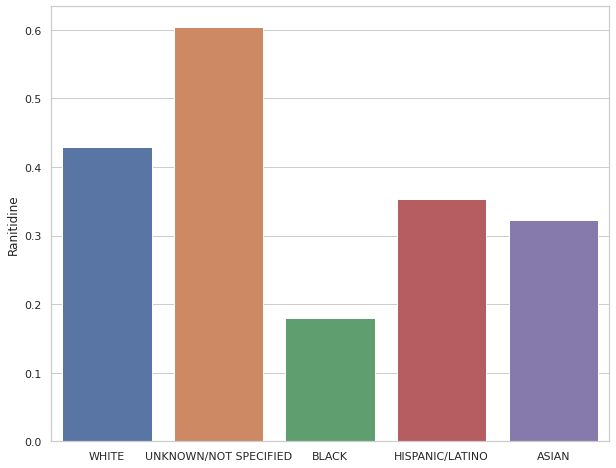

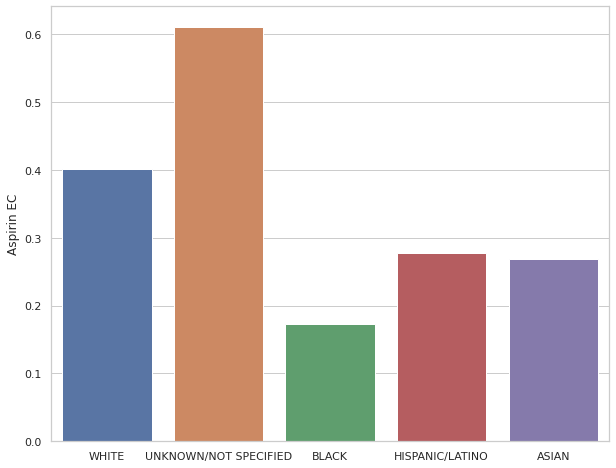

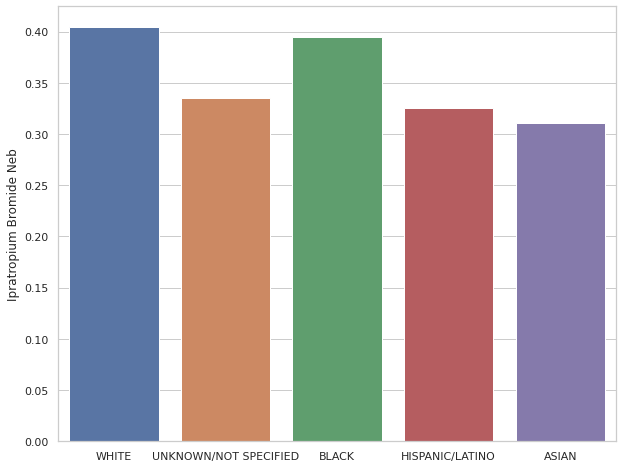

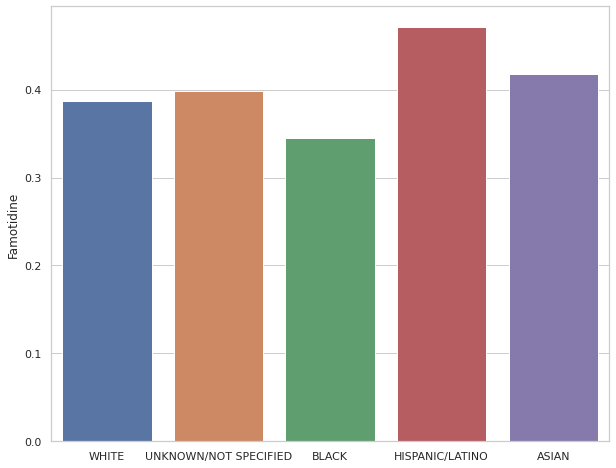

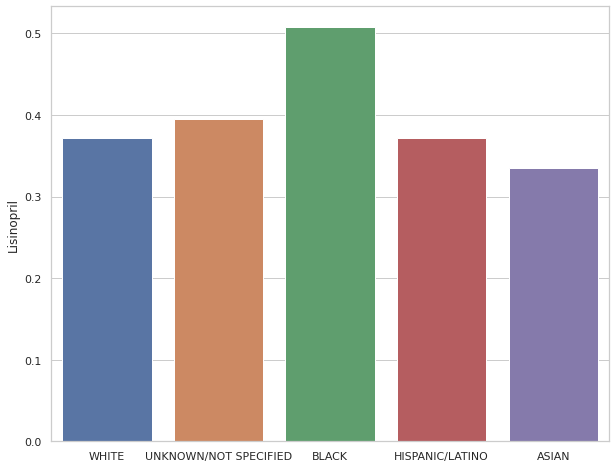

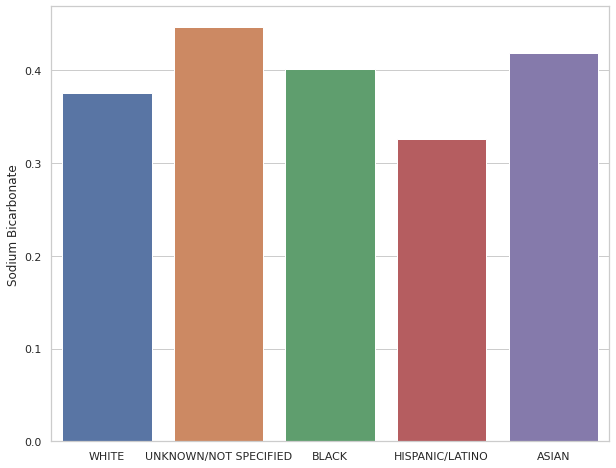

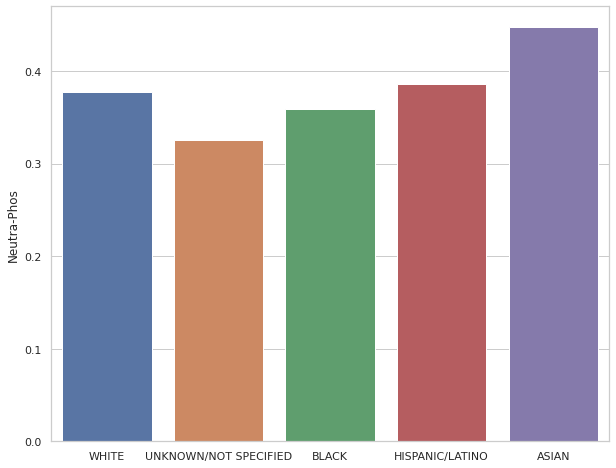

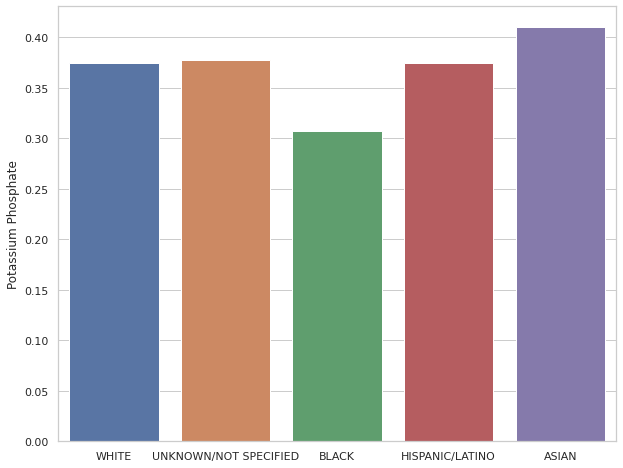

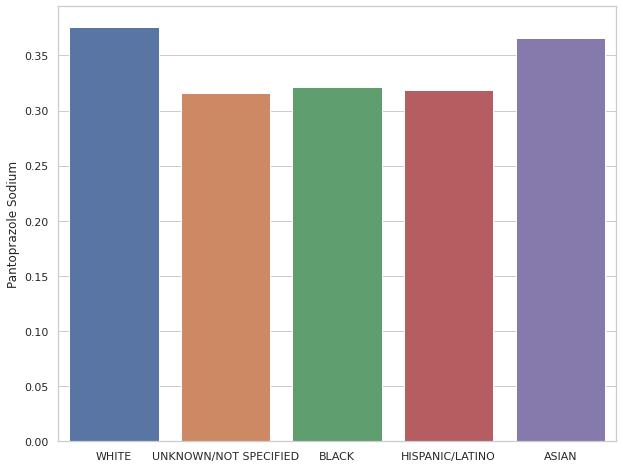

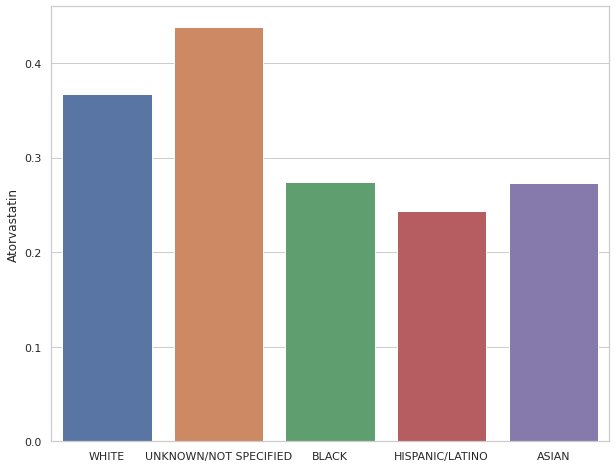

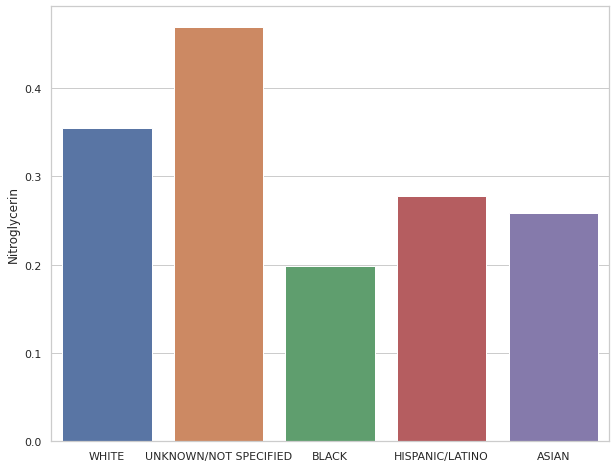

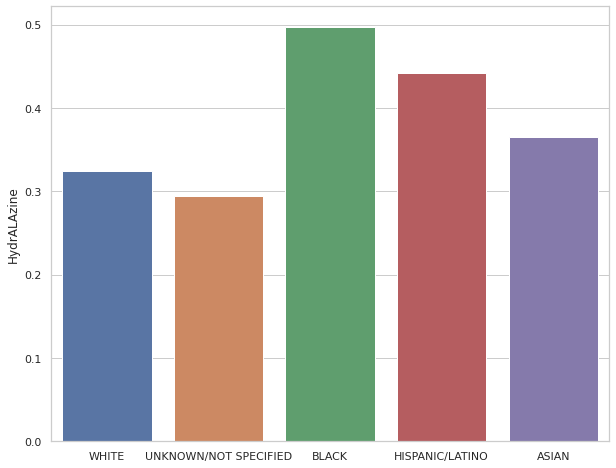

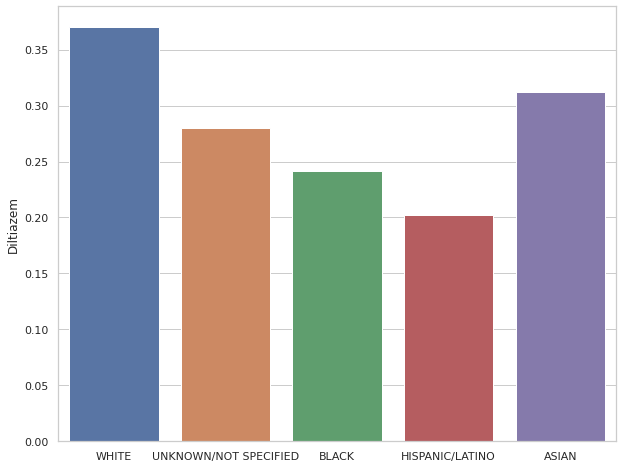

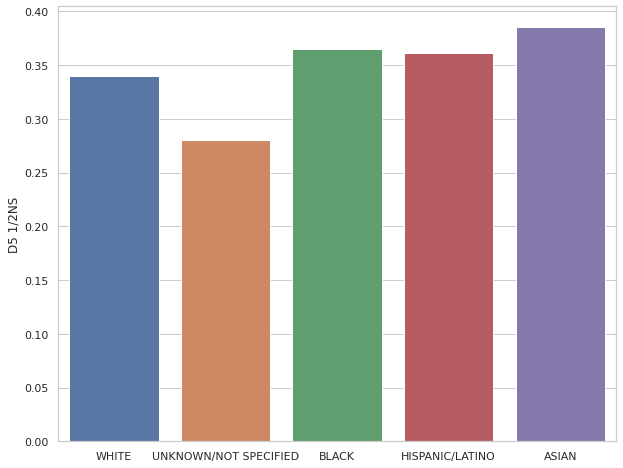

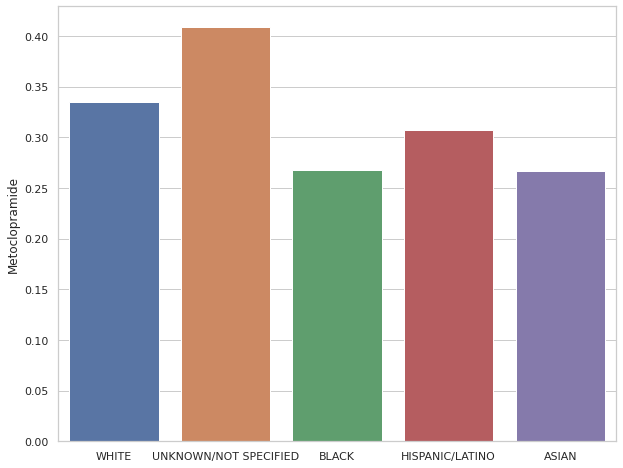

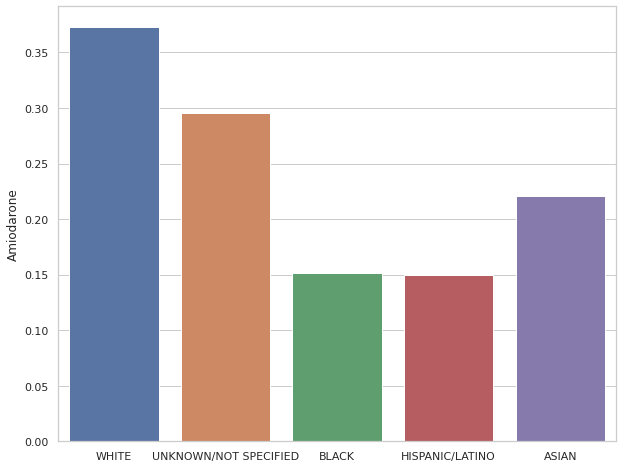

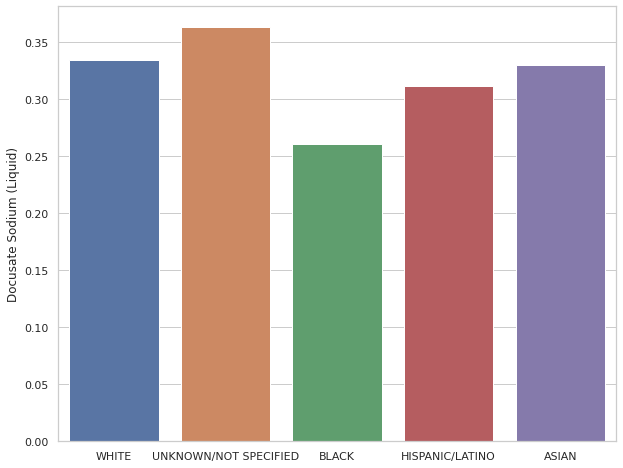

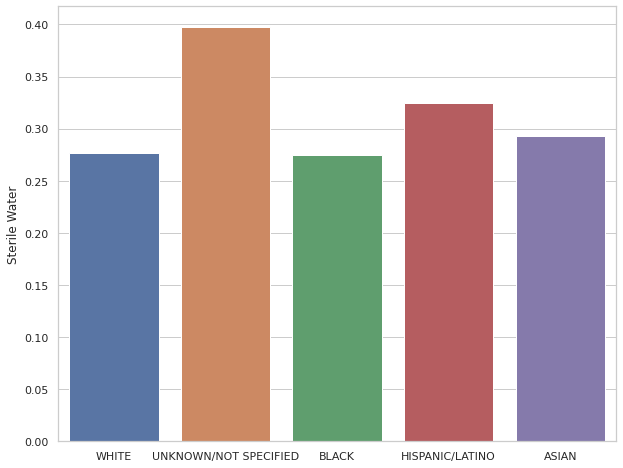

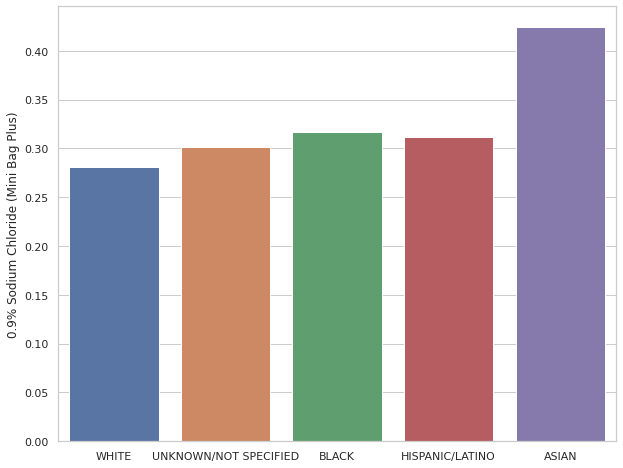

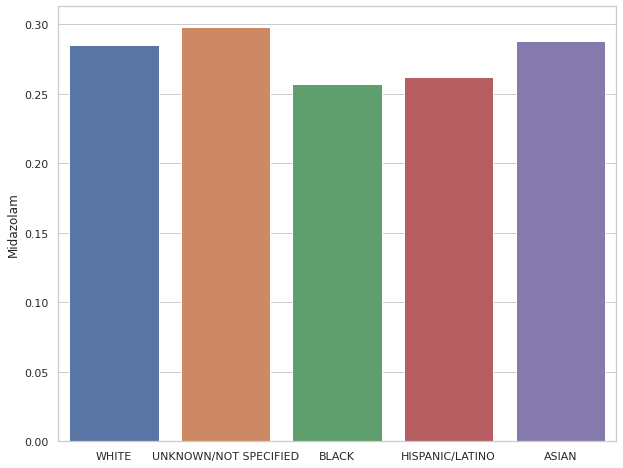

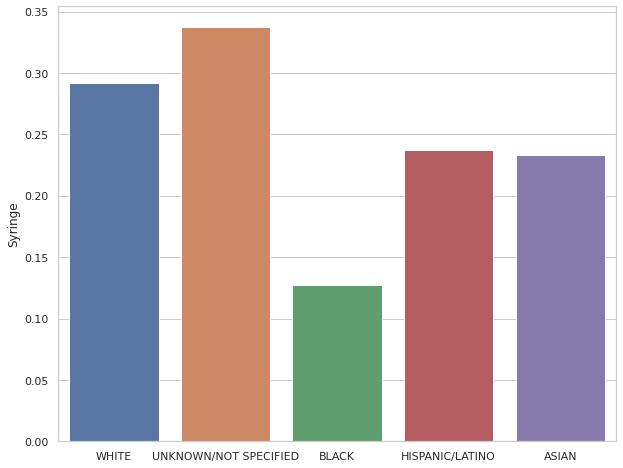

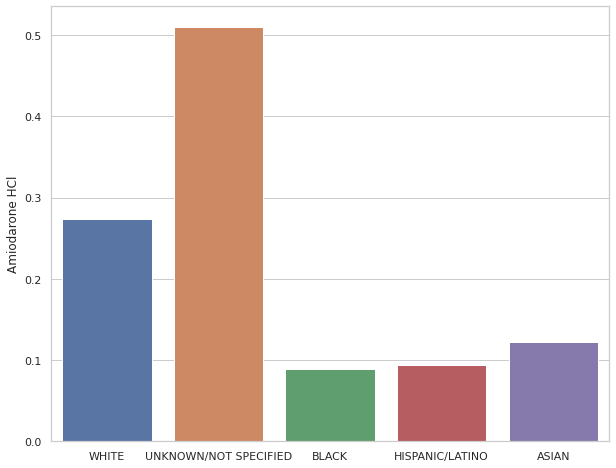

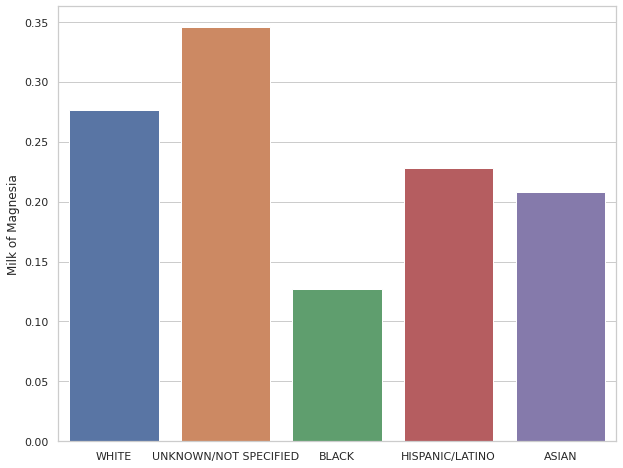

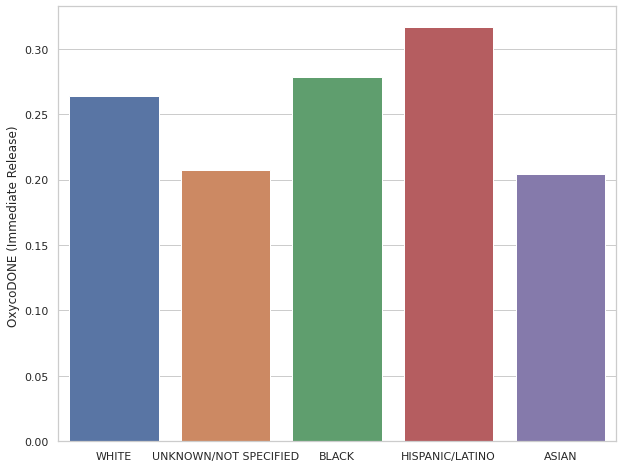

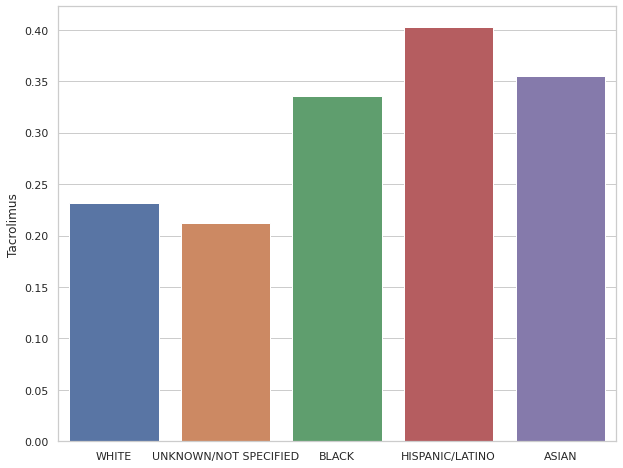

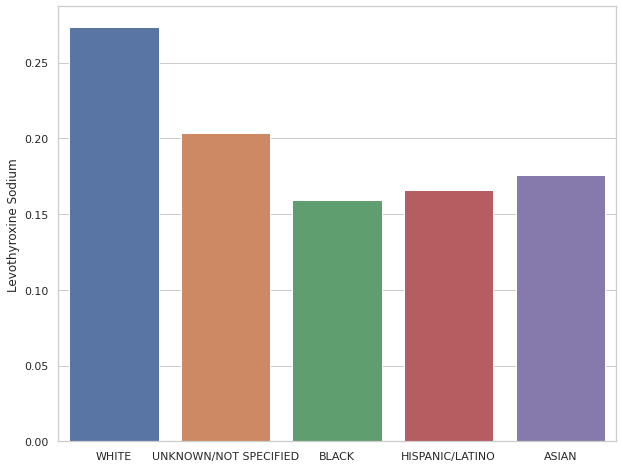

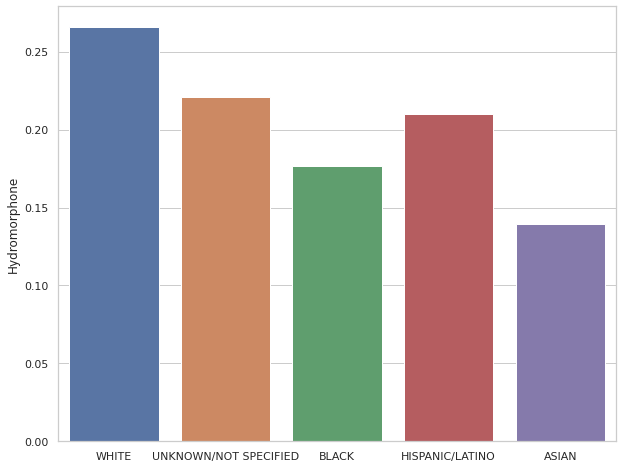

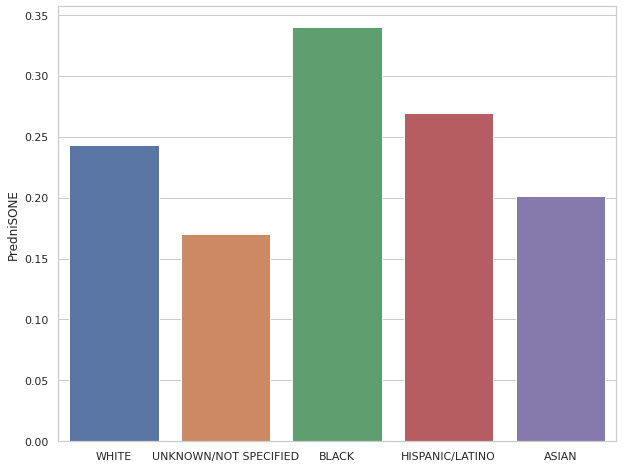

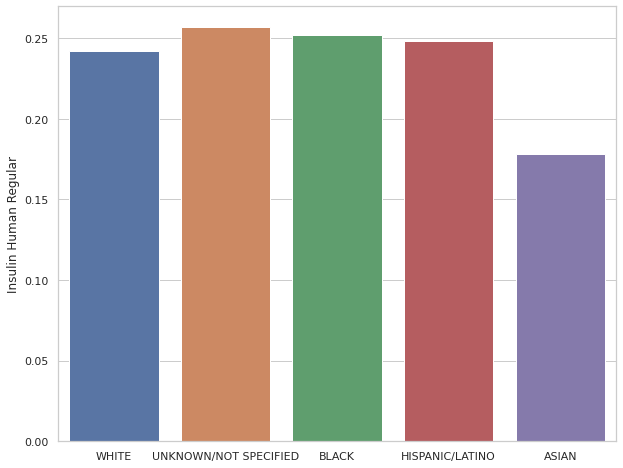

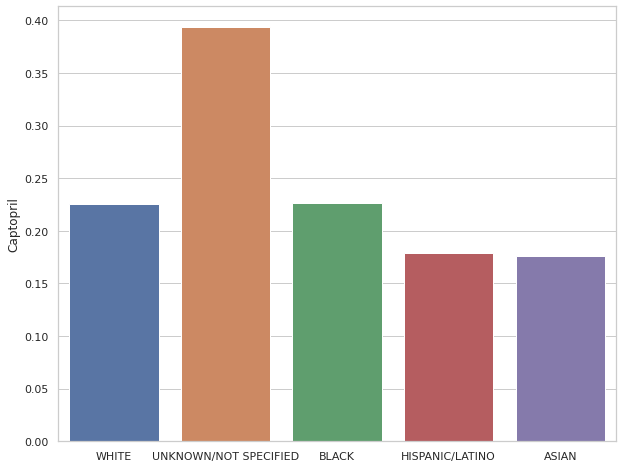

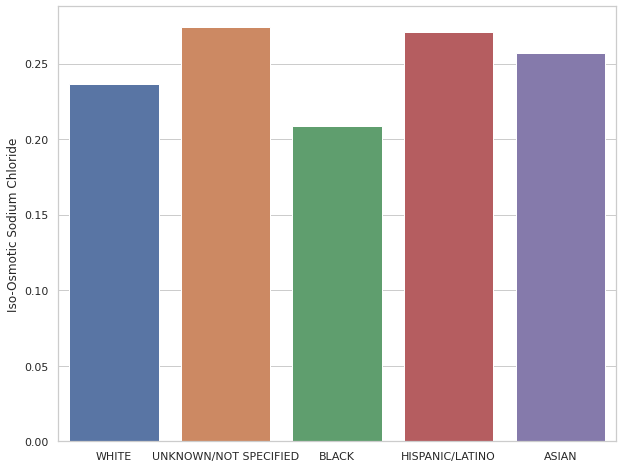

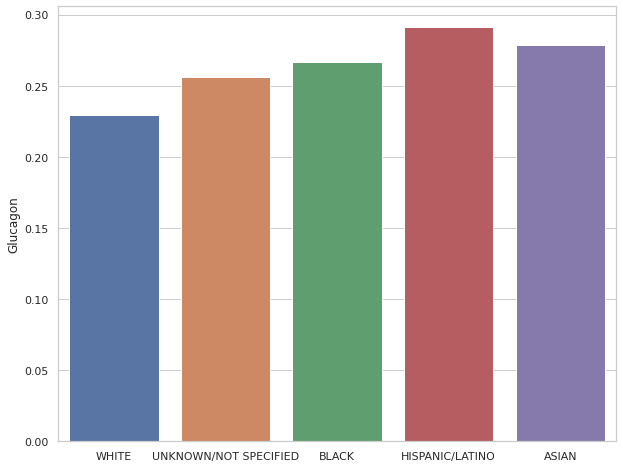

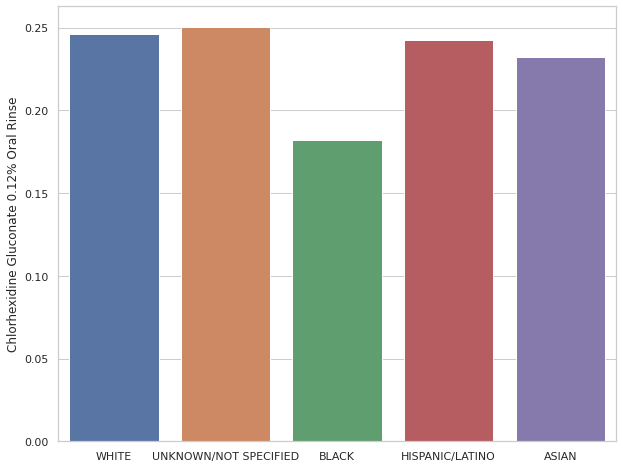

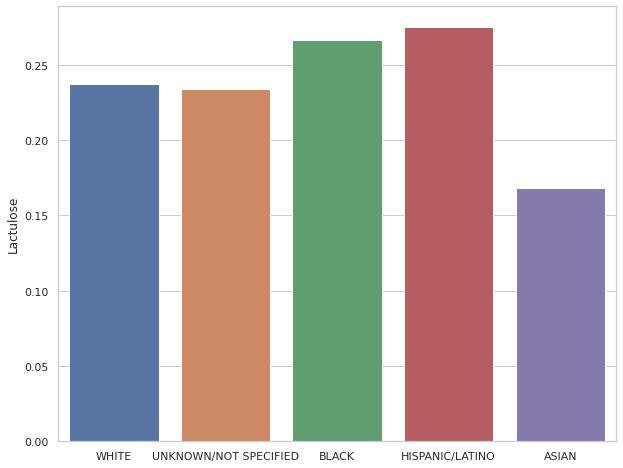

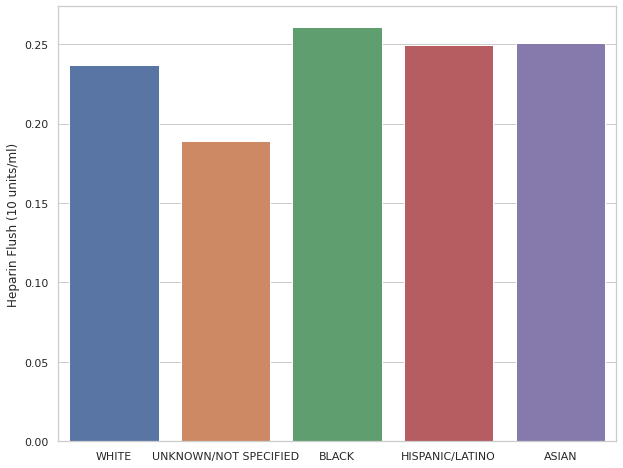

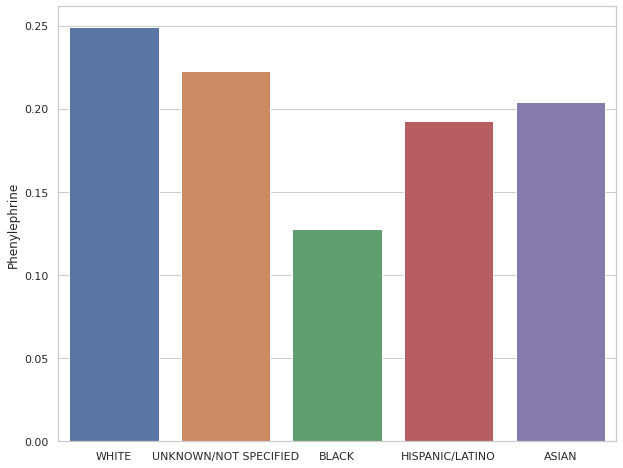

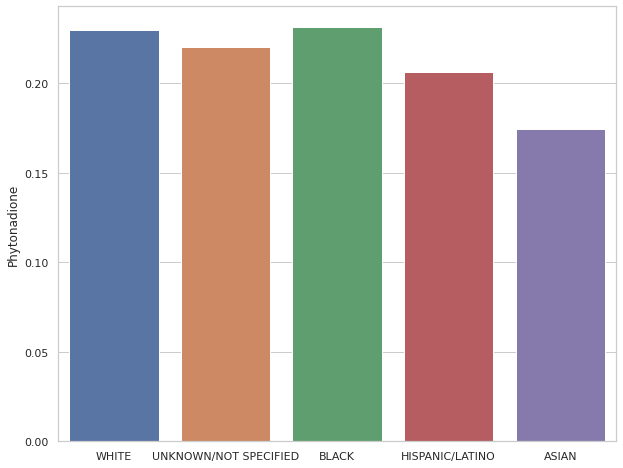

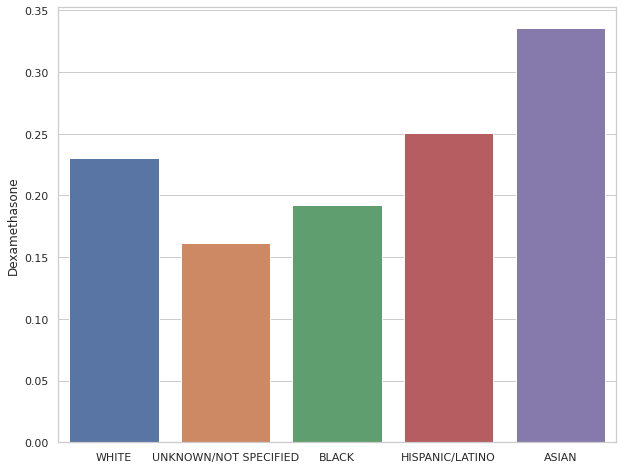

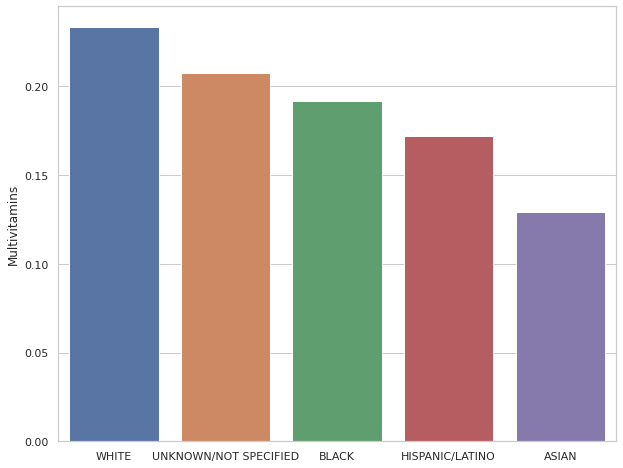

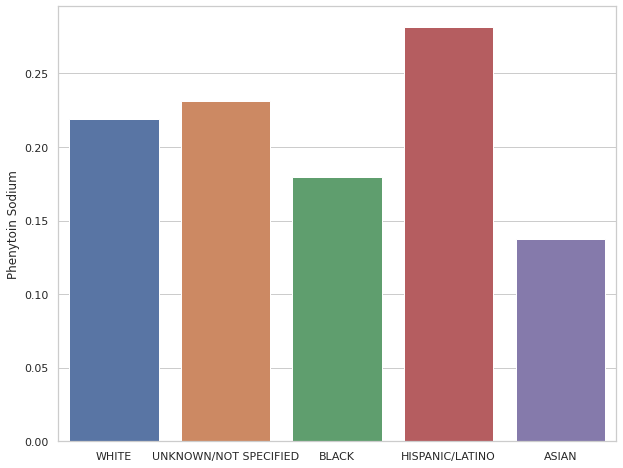

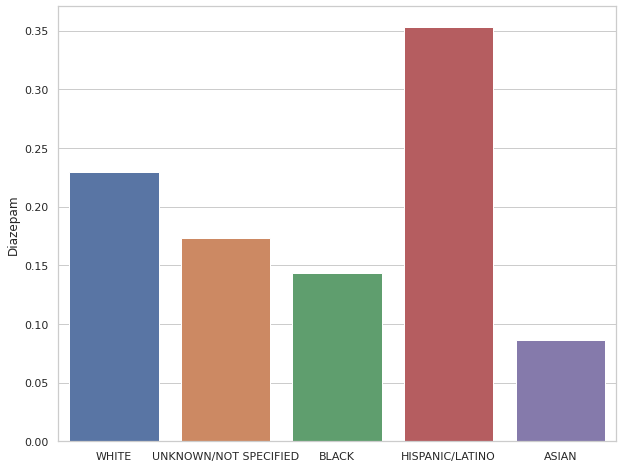

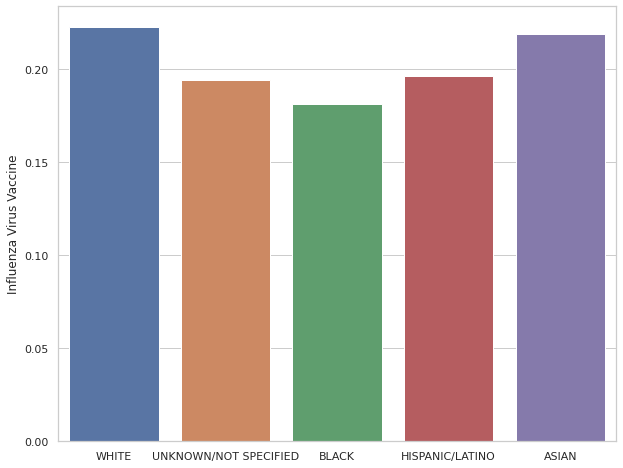

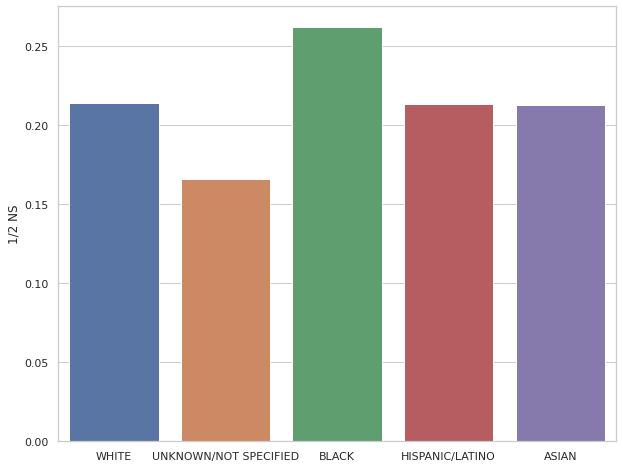

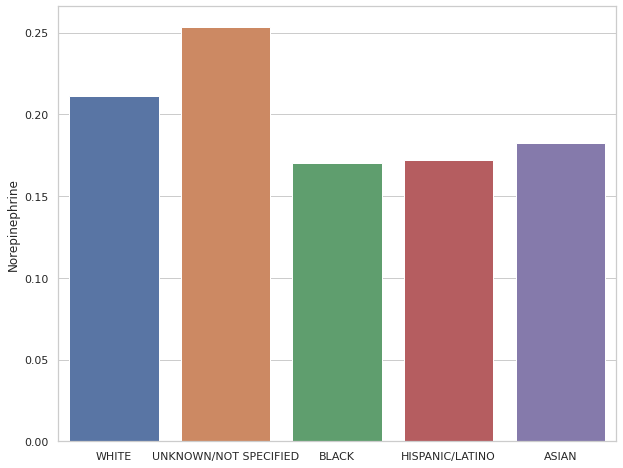

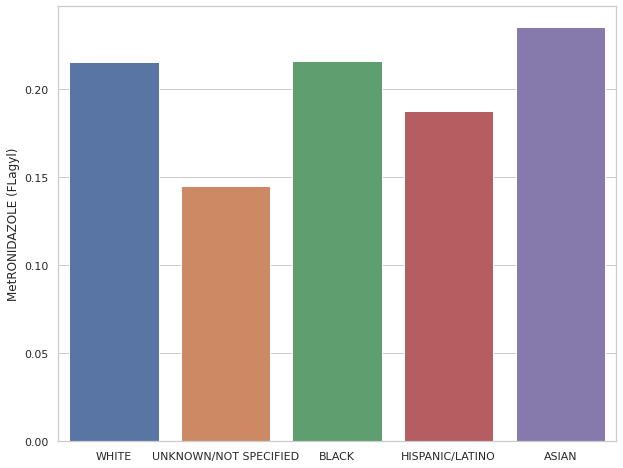

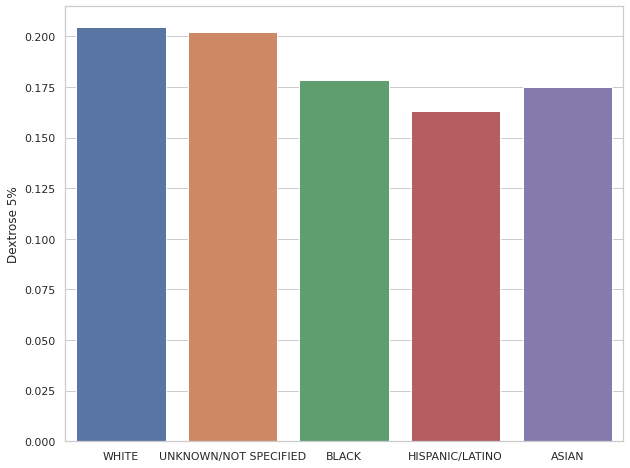

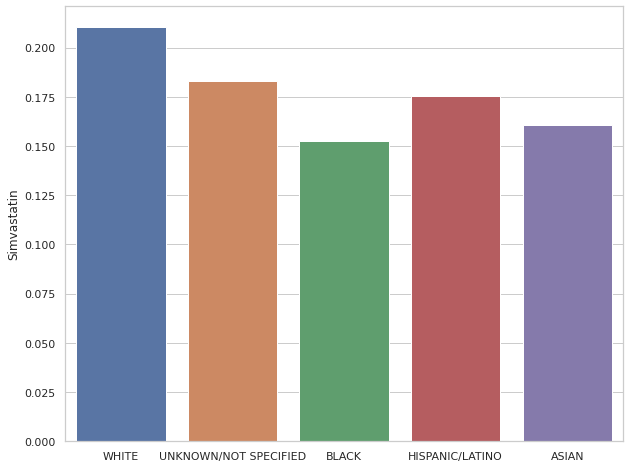

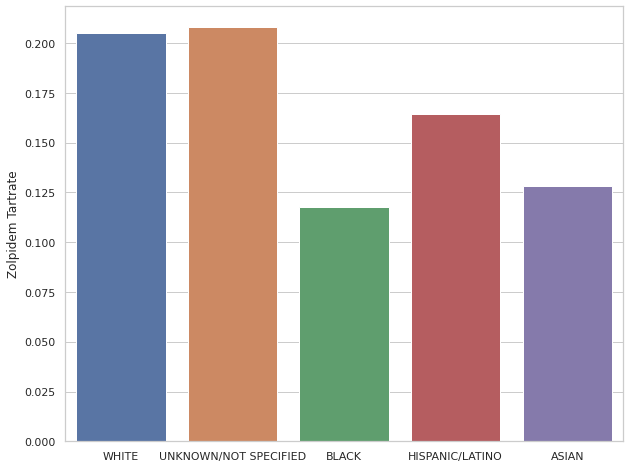

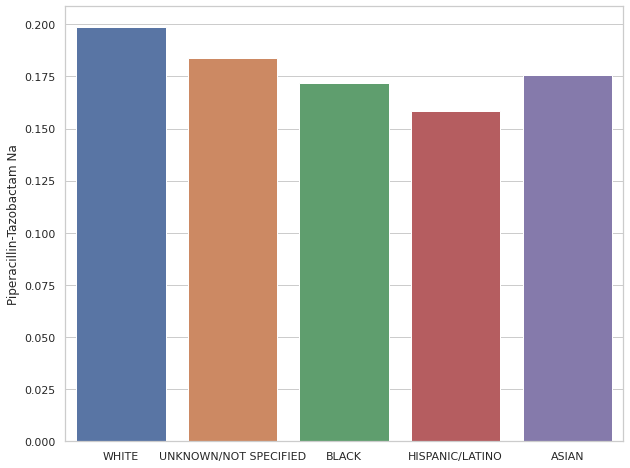

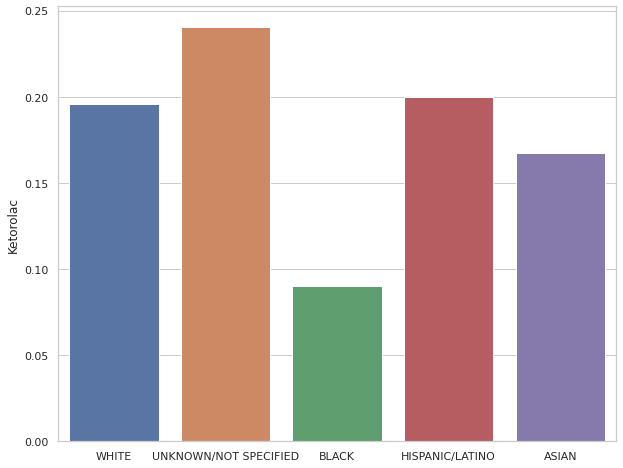

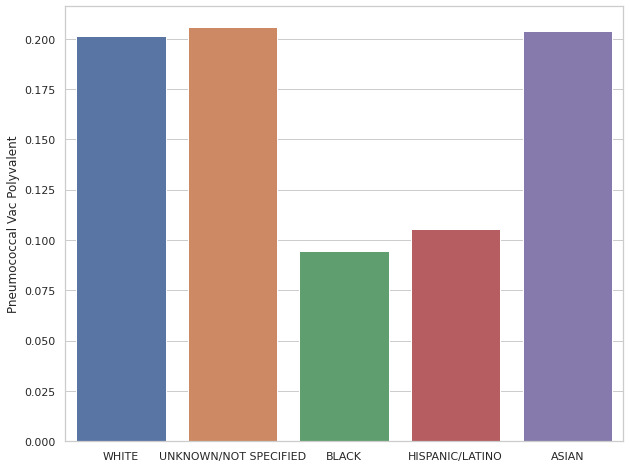

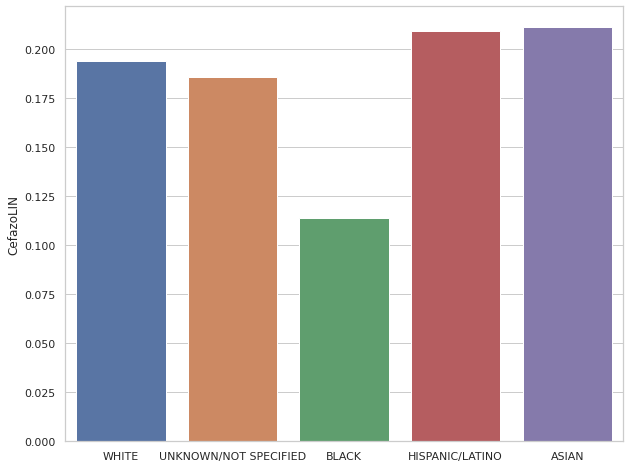

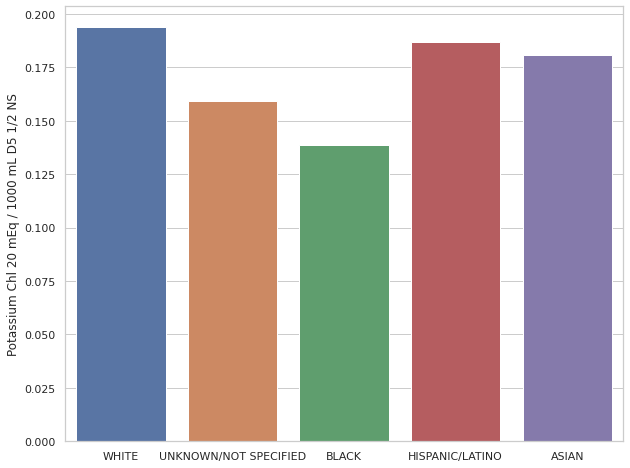

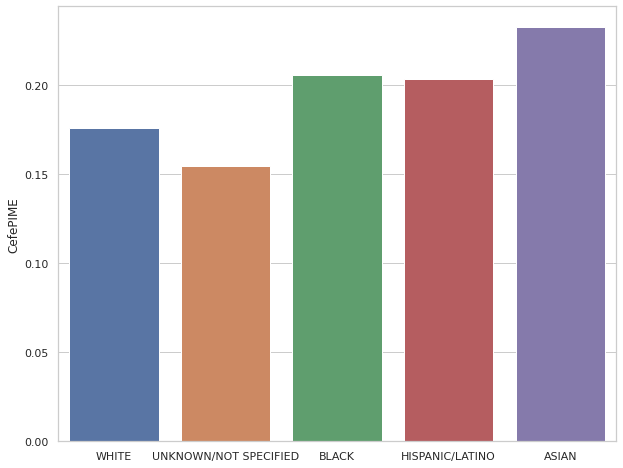

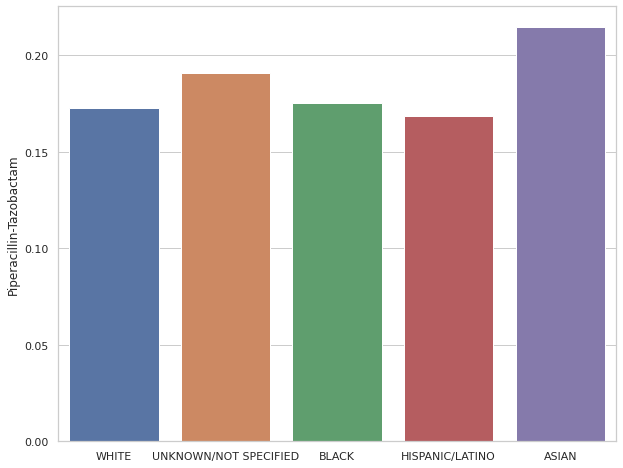

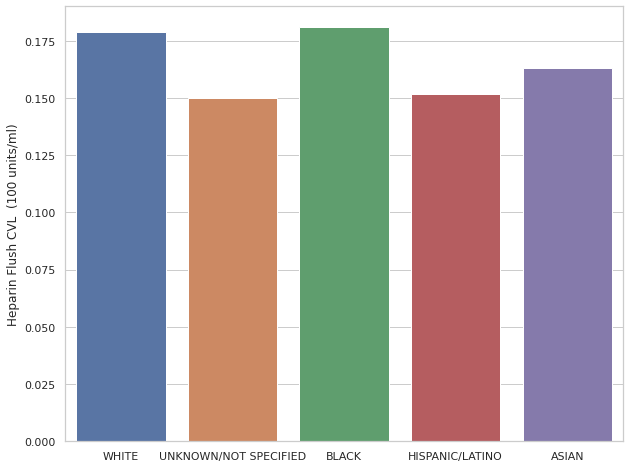

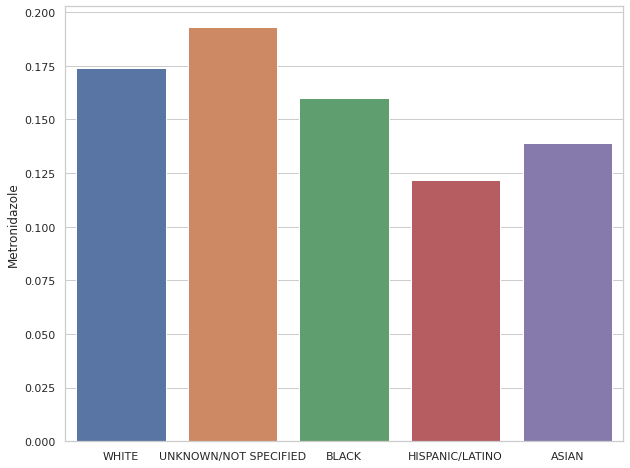

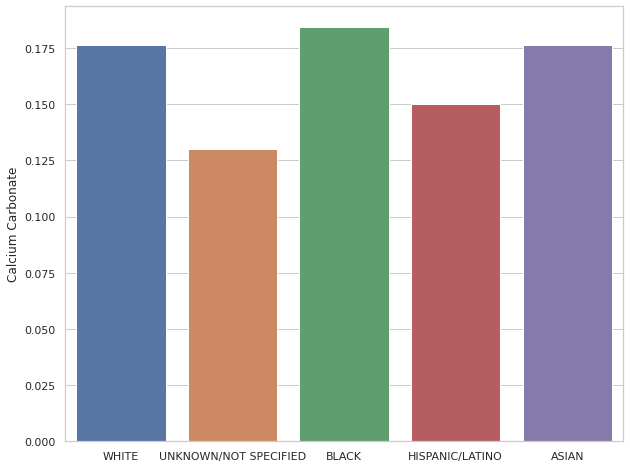

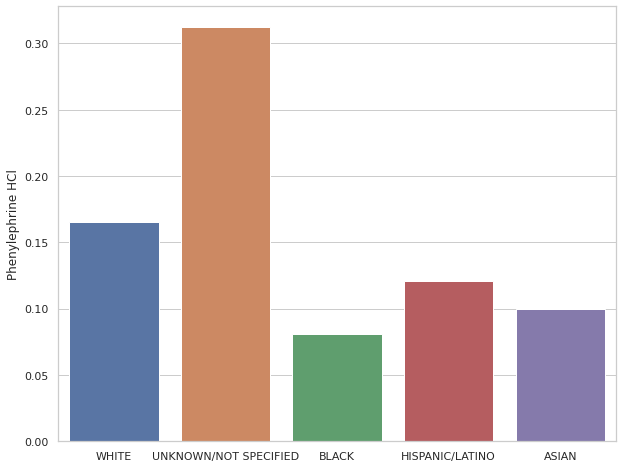

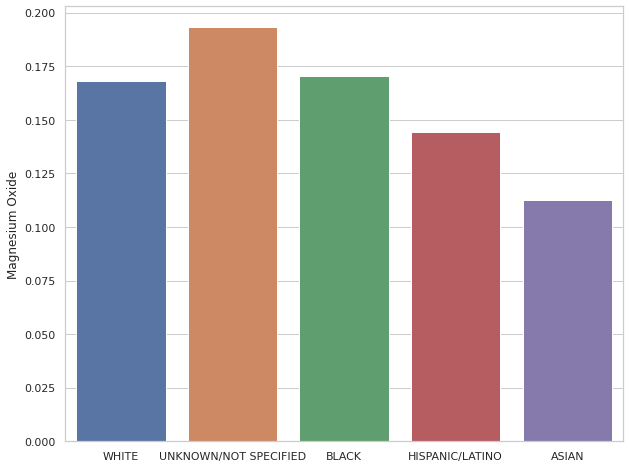

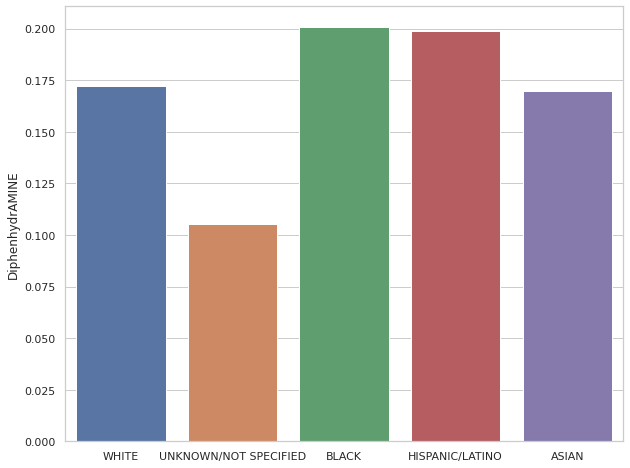

In [ ]:
for drug in data.keys():
  if drug != 'ETHNICITY':
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=(7,7))
    sns.barplot(x=ls_ethnicity, y=drug, ax=ax, data=data)

In [ ]:
# Look at the median LOS by diagnosis category

results = []
for race in ls_ethnicity:
  for drug in ls_drugs:
    results.append(tmp_final[[race, drug]].groupby(race).mean().reset_index().values[1][1])

In [ ]:
sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(100,100))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(ls_drugs)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(drug))

### Top 10 Drugs for Pneumonia

In [ ]:
drug_10_pneumonia = df_prescr.loc[df_prescr['SUBJECT_ID'].isin(patient_pneumonia), 'DRUG'].value_counts().nlargest(10).keys().to_numpy()
print(drug_10_pneumonia)

['Potassium Chloride' '0.9% Sodium Chloride' 'Furosemide' 'Insulin' 'NS'
 'Iso-Osmotic Dextrose' 'D5W' 'Sodium Chloride 0.9%  Flush'
 'Magnesium Sulfate' '5% Dextrose']


In [ ]:
df_prescr_cl = df_prescr.loc[(df_prescr['SUBJECT_ID'].isin(patient_pneumonia)) & (df_prescr['DRUG'].isin(drug_10_pneumonia))].copy()
print(df_prescr_cl.shape)
df_prescr_cl.head()

(79331, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
3223,1548866,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,BASE,NS,NaN,NaN,NS500,001210,338004903.0,500mL Bag,500,ml,500,ml,IV
3226,1549531,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Potassium Chloride,NaN,NaN,KCL40I,001255,74665305.0,2mEq/mL-20mL,40,mEq,20,ml,IV
3235,1548832,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.0,Syringe,3,ml,0.6,SYR,IV
3238,1549565,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.0,Syringe,3,ml,0.6,SYR,IV
3239,1549564,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.0,Syringe,3,ml,0.6,SYR,IV


In [ ]:
df_prescr_cl = pd.concat([df_prescr_cl, pd.get_dummies(df_prescr_cl['DRUG'], prefix='DRUG')], axis=1)
df_prescr_cl.drop(['DRUG'], axis=1)
df_prescr_cl.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE,DRUG_0.9% Sodium Chloride,DRUG_5% Dextrose,DRUG_D5W,DRUG_Furosemide,DRUG_Insulin,DRUG_Iso-Osmotic Dextrose,DRUG_Magnesium Sulfate,DRUG_NS,DRUG_Potassium Chloride,DRUG_Sodium Chloride 0.9% Flush,DRUG_0.9% Sodium Chloride,DRUG_5% Dextrose,DRUG_D5W,DRUG_Furosemide,DRUG_Insulin,DRUG_Iso-Osmotic Dextrose,DRUG_Magnesium Sulfate,DRUG_NS,DRUG_Potassium Chloride,DRUG_Sodium Chloride 0.9% Flush
3223,1548866,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,BASE,NS,NaN,NaN,NS500,001210,338004903.0,500mL Bag,500,ml,500,ml,IV,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3226,1549531,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Potassium Chloride,NaN,NaN,KCL40I,001255,74665305.0,2mEq/mL-20mL,40,mEq,20,ml,IV,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3235,1548832,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.0,Syringe,3,ml,0.6,SYR,IV,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3238,1549565,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.0,Syringe,3,ml,0.6,SYR,IV,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3239,1549564,68,170467,225771.0,2173-12-31 00:00:00,2174-01-01 00:00:00,MAIN,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0.0,Syringe,3,ml,0.6,SYR,IV,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


AttributeError: ignored

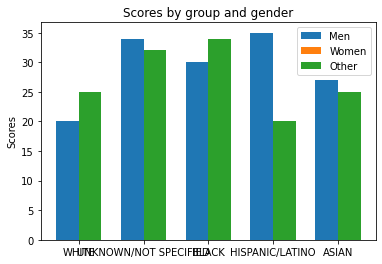

In [ ]:
labels = ['WHITE', 'UNKNOWN/NOT SPECIFIED', 'BLACK', 'HISPANIC/LATINO', 'ASIAN']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')
rects3 = ax.bar(x + width/2, women_means, width, label='Other')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## SERVICES.csv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/SERVICES.csv')
print(df.shape)
df.head()

(73343, 6)


,ROW_ID,SUBJECT_ID,HADM_ID,TRANSFERTIME,PREV_SERVICE,CURR_SERVICE
0,758,471,135879,2122-07-22 14:07:27,TSURG,MED
1,759,471,135879,2122-07-26 18:31:49,MED,TSURG
2,760,472,173064,2172-09-28 19:22:15,NaN,CMED
3,761,473,129194,2201-01-09 20:16:45,NaN,NB
4,762,474,194246,2181-03-23 08:24:41,NaN,NB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73343 entries, 0 to 73342
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ROW_ID        73343 non-null  int64 
 1   SUBJECT_ID    73343 non-null  int64 
 2   HADM_ID       73343 non-null  int64 
 3   TRANSFERTIME  73343 non-null  object
 4   PREV_SERVICE  14668 non-null  object
 5   CURR_SERVICE  73343 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.4+ MB


In [ ]:
df.isnull().sum() # Look into whether missing data exist

ROW_ID              0
SUBJECT_ID          0
HADM_ID             0
TRANSFERTIME        0
PREV_SERVICE    58675
CURR_SERVICE        0
dtype: int64

In [ ]:
df_services = df.copy()

## ICUSTAYS.csv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/ICUSTAYS.csv')
print(df.shape)
df.head()

(61532, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [ ]:
# The missing data in OUTTIME and LOS may be a case that there were 10 patients who were still staying in ICU when this database was created.
df.isnull().sum()

ROW_ID             0
SUBJECT_ID         0
HADM_ID            0
ICUSTAY_ID         0
DBSOURCE           0
FIRST_CAREUNIT     0
LAST_CAREUNIT      0
FIRST_WARDID       0
LAST_WARDID        0
INTIME             0
OUTTIME           10
LOS               10
dtype: int64

In [ ]:
df_icustays = df.copy()

# Hypothesis

In [ ]:
df_admissions['DIAGNOSIS'].value_counts()

NEWBORN                                                                   7823
PNEUMONIA                                                                 1566
SEPSIS                                                                    1184
CONGESTIVE HEART FAILURE                                                   928
CORONARY ARTERY DISEASE                                                    840
                                                                          ... 
NEW DVT                                                                      1
AORTIC STENOSIS\AVR;? CORONARY ARTERY BYPASS GRAFT  /SDA                     1
RIGHT INTERNAL ARTERY STENOSIS;CHEST PAIN;LOWER EXTREMITY CLAUDICATION       1
ACUTE LOWER EXTREMITY ISCHEMIA                                               1
INTERMITTENT CHEST PAIN                                                      1
Name: DIAGNOSIS, Length: 15691, dtype: int64

In [ ]:
df_admissions['DIAGNOSIS'].count()

58951

In [ ]:
df_admissions['DIAGNOSIS'].value_counts()

NEWBORN                                                                   7823
PNEUMONIA                                                                 1566
SEPSIS                                                                    1184
CONGESTIVE HEART FAILURE                                                   928
CORONARY ARTERY DISEASE                                                    840
                                                                          ... 
NEW DVT                                                                      1
AORTIC STENOSIS\AVR;? CORONARY ARTERY BYPASS GRAFT  /SDA                     1
RIGHT INTERNAL ARTERY STENOSIS;CHEST PAIN;LOWER EXTREMITY CLAUDICATION       1
ACUTE LOWER EXTREMITY ISCHEMIA                                               1
INTERMITTENT CHEST PAIN                                                      1
Name: DIAGNOSIS, Length: 15691, dtype: int64

# Explore Data

### ADMISSIONS.csv

There are 4 types of the admission as below.

Q. What is the difference between Emergency and Urgent?

A. According to the description in Physionet, Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies.

In [ ]:
df_admissions['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'ELECTIVE', 'NEWBORN', 'URGENT'], dtype=object)

Join those two types into a single one named EMERGENCY

In [ ]:
df_admissions['ADMISSION_TYPE'] = df_admissions['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY')
df_admissions['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'ELECTIVE', 'NEWBORN'], dtype=object)

In [ ]:
df_admissions['ADMISSION_TYPE'].value_counts()

EMERGENCY    43407
NEWBORN       7863
ELECTIVE      7706
Name: ADMISSION_TYPE, dtype: int64

#### Hypothesis #1

Hospitals might give better clinical services to patients who are admitted due to particular diseases that require using profitable equipments or medications.

CSURG

NSURG

ORTHO


### SERVICES.csv

In [ ]:
arr_service_type = df_services['CURR_SERVICE'].unique()

df_services['CURR_SERVICE'].value_counts()

MED      24866
CMED      9135
CSURG     7911
NB        7806
SURG      5514
NSURG     4100
TRAUM     3137
NMED      2957
OMED      2286
VSURG     1455
TSURG     1338
ORTHO     1101
GU         436
NBB        346
GYN        306
PSURG      283
ENT        247
OBS        113
DENT         5
PSYCH        1
Name: CURR_SERVICE, dtype: int64

In [ ]:
service_surg = []
service_non_surg = []

for service_type in arr_service_type:
  if 'SURG' in service_type:
    service_surg.append(service_type)
  else:
    service_non_surg.append(service_type)


print(service_surg)
print(service_non_surg)

['TSURG', 'SURG', 'CSURG', 'VSURG', 'NSURG', 'PSURG']
['MED', 'CMED', 'NB', 'NBB', 'NMED', 'TRAUM', 'OMED', 'ORTHO', 'GU', 'ENT', 'GYN', 'OBS', 'DENT', 'PSYCH']


In [ ]:
# Make a dataframe of patients who were under surgerical services

print(df_services[df_services['CURR_SERVICE'].isin(service_surg) == True].shape)
df_services[df_services['CURR_SERVICE'].isin(service_surg) == True].head(10)

(20601, 6)


,ROW_ID,SUBJECT_ID,HADM_ID,TRANSFERTIME,PREV_SERVICE,CURR_SERVICE
1,759,471,135879,2122-07-26 18:31:49,MED,TSURG
11,769,479,148420,2179-09-21 10:09:00,MED,SURG
12,770,480,182365,2166-08-07 14:33:16,NaN,SURG
17,775,485,116665,2195-02-18 18:27:32,NaN,CSURG
18,776,487,160958,2130-10-31 00:47:23,NaN,CSURG
20,778,489,145439,2194-09-29 19:02:07,NaN,CSURG
30,788,498,127076,2151-04-26 14:21:39,CMED,CSURG
32,790,500,141591,2200-03-14 01:47:22,NaN,VSURG
42,800,507,148905,2146-06-22 00:59:00,NaN,SURG
43,801,507,136251,2148-09-15 11:28:48,NaN,CSURG


In [ ]:
# Make a list of patients who were under surgerical servics

patient_surg = df_services[df_services['CURR_SERVICE'].isin(service_surg) == True]['SUBJECT_ID'].drop_duplicates().to_numpy()
type(patient_surg)
patient_surg

array([  471,   479,   480, ..., 98899, 98905, 98941])

In [ ]:
# Make a dataframe of patients who were under surgerical services

print(df_services[df_services['CURR_SERVICE'].isin(service_non_surg) == True].shape)
df_services[df_services['CURR_SERVICE'].isin(service_non_surg)].head(10)

(52742, 6)


,ROW_ID,SUBJECT_ID,HADM_ID,TRANSFERTIME,PREV_SERVICE,CURR_SERVICE
0,758,471,135879,2122-07-22 14:07:27,TSURG,MED
2,760,472,173064,2172-09-28 19:22:15,NaN,CMED
3,761,473,129194,2201-01-09 20:16:45,NaN,NB
4,762,474,194246,2181-03-23 08:24:41,NaN,NB
5,763,474,146746,2181-04-04 17:38:46,NaN,NBB
6,764,475,139351,2131-09-16 18:44:04,NaN,NB
7,765,476,161042,2100-07-05 10:26:45,NaN,NB
8,766,477,191025,2156-07-20 11:53:03,NaN,MED
9,767,478,137370,2194-07-15 13:55:21,NaN,NB
10,768,479,148420,2179-09-20 06:53:00,NaN,MED


In [ ]:
# Make a list of patients who were not under surgerical servics

patient_no_surg = df_services[df_services['CURR_SERVICE'].isin(service_non_surg)]['SUBJECT_ID'].drop_duplicates().to_numpy()
patient_no_surg

array([  471,   472,   473, ..., 98939, 98943, 98944])

### ICUSTAYS.csv

In [ ]:
# Round the values of length of stay in ICU into zero

df_icustays['LOS'] = df_icustays['LOS'].round(0)
print(df_icustays)
df_icustays.head()

       ROW_ID  SUBJECT_ID  ...              OUTTIME  LOS
0         365         268  ...  2198-02-18 05:26:11  3.0
1         366         269  ...  2170-11-08 17:46:57  3.0
2         367         270  ...  2128-06-27 12:32:29  3.0
3         368         271  ...  2120-08-10 00:39:04  2.0
4         369         272  ...  2186-12-27 12:01:13  2.0
...       ...         ...  ...                  ...  ...
61527   59806       94944  ...  2104-04-17 14:51:00  2.0
61528   59807       94950  ...  2155-12-10 17:24:58  2.0
61529   59808       94953  ...  2160-03-04 14:22:33  1.0
61530   59809       94954  ...  2183-03-27 17:55:03  2.0
61531   59810       94956  ...  2157-05-23 14:58:04  5.0

[61532 rows x 12 columns]


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.0
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.0
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,3.0
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,2.0


In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_surg)]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0
6,371,274,130546,254851,carevue,MICU,MICU,12,12,2114-06-28 22:28:44,2114-07-07 18:01:16,9.0
18,383,286,106909,260225,carevue,MICU,MICU,52,52,2175-12-31 22:57:27,2176-02-24 19:16:58,55.0
19,384,286,135917,240627,carevue,SICU,SICU,57,57,2176-04-10 20:46:09,2176-04-12 16:42:47,2.0
20,385,287,174293,270957,carevue,SICU,TSICU,23,33,2167-05-22 16:13:33,2167-05-25 16:04:56,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61525,59804,94937,156213,293838,metavision,SICU,SICU,57,57,2107-02-05 17:16:52,2107-02-06 21:53:10,1.0
61526,59805,94942,188423,264655,metavision,SICU,SICU,33,33,2179-12-25 19:07:29,2179-12-26 16:24:45,1.0
61527,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.0
61529,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,1.0


In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_surg)].mean(axis=0)

ROW_ID           31911.825480
SUBJECT_ID       35682.762781
HADM_ID         149923.598737
ICUSTAY_ID      249812.353514
FIRST_WARDID        26.596382
LAST_WARDID         26.468356
LOS                  4.531115
dtype: float64

In [ ]:
los_max_surg = df_icustays[df_icustays['SUBJECT_ID'].isin(patient_surg)]['LOS'].max()
los_min_surg = df_icustays[df_icustays['SUBJECT_ID'].isin(patient_surg)]['LOS'].min()

print('Max length of stay in ICD for patients under surgerical services is {} and Min is {}'.format(los_max_surg, los_min_surg))

Max length of stay in ICD for patients under surgerical services is 173.0 and Min is 0.0


In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_no_surg)]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.0
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.0
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,3.0
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61524,59803,94937,162005,280084,metavision,CSRU,CSRU,15,15,2107-01-18 11:11:21,2107-01-19 14:37:37,1.0
61525,59804,94937,156213,293838,metavision,SICU,SICU,57,57,2107-02-05 17:16:52,2107-02-06 21:53:10,1.0
61527,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.0
61528,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.0


In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_no_surg)].mean(axis=0)

ROW_ID           30002.699984
SUBJECT_ID       32648.159098
HADM_ID         150003.159236
ICUSTAY_ID      249935.042309
FIRST_WARDID        34.924690
LAST_WARDID         34.737590
LOS                  5.058406
dtype: float64

In [ ]:
los_max_no_surg = df_icustays[df_icustays['SUBJECT_ID'].isin(patient_no_surg)]['LOS'].max()
los_min_no_surg = df_icustays[df_icustays['SUBJECT_ID'].isin(patient_no_surg)]['LOS'].min()

print('Max length of stay in ICD for patients under surgerical services is {} and Min is {}'.format(los_max_no_surg, los_min_no_surg))

Max length of stay in ICD for patients under surgerical services is 172.0 and Min is 0.0


### Conclusion

It is hard to find meaningful difference of the length of stay between one having surgerical service and the other having non-surgerical services

In [ ]:
print('The longest stay in ICU is {max}, and the shortest is {min}'.format(max=df_icustays['LOS'].max(), min=df_icustays['LOS'].min()))

The longest stay in ICU is 173.0, and the shortest is 0.0


In [ ]:
arr_los = np.sort(df_icustays['LOS'][df_icustays['LOS'].notnull()].unique())

#### Hypothesis #2

Hospitals might give better clinical services to patients who are registered for private insurance plan than the others.


The American health care system for years has provided many hospitals with a clear playbook for turning a profit: Provide surgeries, scans and other well-reimbursed services to privately insured patients, whose plans pay higher prices than public programs like Medicare and Medicaid.

excerpt from https://www.nytimes.com/2020/05/15/us/hospitals-revenue-coronavirus.html#:~:text=The%20American%20health%20care%20system,programs%20like%20Medicare%20and%20Medicaid.

In [ ]:
#print(df_admissions['INSURANCE'].unique())

df_admissions['INSURANCE'].value_counts()

Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: INSURANCE, dtype: int64

In [ ]:
df_admissions['INSURANCE']= df_admissions['INSURANCE'].replace('Medicare', 'Non-Private').replace('Medicaid', 'Non-Private').replace('Government', 'Non-Private').replace('Self Pay', 'Non-Private')
df_admissions['INSURANCE'].value_counts()

Non-Private    36394
Private        22582
Name: INSURANCE, dtype: int64

In [ ]:
df_admissions[df_admissions['INSURANCE'] == 'Private']

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
20,41,39,106266,2114-11-29 21:04:00,2114-12-09 15:10:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,NEWBORN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58968,58591,98790,187987,2200-10-15 01:58:00,2200-10-25 15:43:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2200-10-14 23:42:00,2200-10-15 04:41:00,JOINT EFFUSION,0,1
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


In [ ]:
patient_private = df_admissions[df_admissions['INSURANCE'] == 'Private']['SUBJECT_ID'].drop_duplicates().to_numpy()
len(patient_private)

19663

In [ ]:
df_admissions[df_admissions['INSURANCE'] == 'Non-Private']

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Non-Private,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Non-Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Non-Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Non-Private,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Non-Private,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58966,58589,98768,127022,2112-09-15 09:45:00,2112-09-17 08:20:00,2112-09-17 08:20:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Non-Private,ENGL,JEWISH,WIDOWED,WHITE,2112-09-15 09:30:00,2112-09-15 11:46:00,LEUKOCYTOSIS,1,1
58967,58590,98769,141860,2125-02-22 22:18:00,2125-03-05 17:22:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Non-Private,ENGL,CATHOLIC,WIDOWED,WHITE,2125-02-22 19:52:00,2125-02-22 22:37:00,ISCHEMIC COLITIS,0,1
58969,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Non-Private,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA,0,1
58970,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Non-Private,ENGL,CATHOLIC,WIDOWED,WHITE,2132-12-24 18:53:00,2132-12-24 21:41:00,ALTERED MENTAL STATUS,1,1


In [ ]:
patient_non_private = df_admissions[df_admissions['INSURANCE'] == 'Non-Private']['SUBJECT_ID'].drop_duplicates().to_numpy()
len(patient_non_private)

27474

In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_private)]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0
5,370,273,158689,241507,carevue,MICU,MICU,52,52,2141-04-19 06:12:05,2141-04-20 17:52:11,1.0
8,373,276,135156,206327,carevue,CCU,CCU,57,57,2147-11-20 09:02:23,2147-11-21 17:08:52,1.0
11,376,280,123506,247496,carevue,NICU,NICU,56,56,2155-12-08 18:22:09,2155-12-22 17:10:45,14.0
17,382,285,165312,238023,carevue,TSICU,TSICU,14,14,2152-09-21 22:48:50,2152-10-20 15:19:31,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61506,59785,94889,147635,207543,metavision,TSICU,TSICU,14,14,2124-10-21 22:56:38,2124-10-27 17:35:23,6.0
61507,59786,94889,147635,252338,metavision,SICU,SICU,57,57,2124-11-22 21:55:59,2124-11-24 18:04:42,2.0
61510,59789,94903,132953,284226,metavision,MICU,MICU,52,52,2181-06-27 10:54:46,2181-06-28 21:50:04,1.0
61529,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,1.0


In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_non_private)]

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.0
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.0
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,3.0
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,2.0
6,371,274,130546,254851,carevue,MICU,MICU,12,12,2114-06-28 22:28:44,2114-07-07 18:01:16,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
61525,59804,94937,156213,293838,metavision,SICU,SICU,57,57,2107-02-05 17:16:52,2107-02-06 21:53:10,1.0
61526,59805,94942,188423,264655,metavision,SICU,SICU,33,33,2179-12-25 19:07:29,2179-12-26 16:24:45,1.0
61527,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.0
61528,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.0


In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_private)].mean(axis=0)

ROW_ID           28608.938543
SUBJECT_ID       30406.237935
HADM_ID         150046.734687
ICUSTAY_ID      249964.142728
FIRST_WARDID        35.902943
LAST_WARDID         35.864014
LOS                  5.542374
dtype: float64

In [ ]:
df_icustays[df_icustays['SUBJECT_ID'].isin(patient_non_private)].mean(axis=0)

ROW_ID           31804.715109
SUBJECT_ID       35598.355080
HADM_ID         149930.452595
ICUSTAY_ID      249962.174797
FIRST_WARDID        31.261469
LAST_WARDID         31.119687
LOS                  4.494119
dtype: float64

Conclusion

It does not seem that the difference of the length of stay is minor between patients having private insurance and patients having others.

In [ ]:
np.sort(df_icustays['LOS'].unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 116., 117., 118., 119., 120., 121.,
       123., 124., 125., 127., 129., 132., 133., 135., 136., 137., 138.,
       139., 141., 142., 144., 145., 146., 148., 149., 151., 154., 168.,
       169., 172., 173.,  nan])

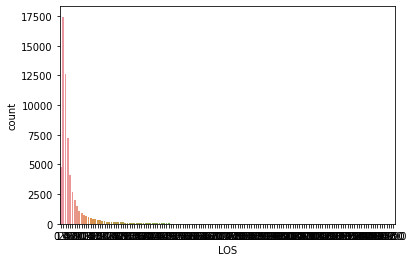

In [ ]:
sns.countplot(x='LOS', data=df_icustays)

Different services even same diagnosis

In [ ]:
df_admissions['DIAGNOSIS']

In [ ]:
df_admissions

NameError: ignored